#  Analyzing and Predicting Player Count Trends in Online Games

## Part 3: Model Construction

We will be utilizing a model known as SARIMAX, or Seasonal Auto-Regressive Integrated Moving Average with Exogenous Regressors. At first, we will not be using exogenous regressors, but we will be eventually incorporating our 'event' column to assess the impact of an ongoing event to our predictor of choice.  

### Modelling Goals

We wish to predict 3 separate things:

1. Number of players at a given time in the future
2. Player growth over a given period
3. Player growth at a given time.

### Modelling Process for SARIMA and SARIMAX

1. Transform Data
    - Outlier Removal
    - Discontinuity
2. Determine Seasonality
    - Spectral Analysis
3. Stationarity
    - ACF & PACF Analysis
4. Model Construction
5. Model Comparison

### Modelling Process for Our Data

We have to ask what exact model we want to construct. Would we want a model that is built on a single game and can only preedict that one game? Or should we build a model that takes an amalgamization of all games, and build a model based upon that? Or perhaps making a model based upon our control dataframe, Team Fortress 2, and seeing how this model performs on other games. 

1. Basic Modelling
    - CSGO
    - DOTA 2
    - Rocket League
    - Team Fortress 2
2. Amalgamized Modelling
    - Amalgamization Technique
    - Modelling
    - Testing


In [1]:
# we import the necessary libraries

import math
from scipy.stats import boxcox as bc
import scipy.stats
import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

fsds v0.2.30 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


[i] Pandas .iplot() method activated.


## Data Retreival

In [2]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
dota = pd.read_csv('data/Clean/dota.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
rl = pd.read_csv('data/Clean/rl.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
tf = pd.read_csv('data/Clean/tf.csv', parse_dates = ['DateTime'], index_col = 'DateTime')

raw_ls = [csgo, dota, rl, tf]

labels = ['CS:GO', "DOTA 2", 'Rocket League', 'Team Fortress 2']

ls = raw_ls

ls[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2195 entries, 2015-01-01 to 2021-01-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2195 non-null   int64  
 1   players       2195 non-null   int64  
 2   viewers       2195 non-null   int64  
 3   event         2195 non-null   object 
 4   %chg_players  2146 non-null   float64
 5   %chg_viewers  1998 non-null   float64
 6   title         2195 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 137.2+ KB


In [3]:
# we also need to drop unnecessary columns

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0']), ls))

In [4]:
ls[0]

players  viewers event  %chg_players  %chg_viewers  title
DateTime                                                             
2015-01-01   443188        0    No           NaN           NaN  CS:GO
2015-01-02   383943        0    No     -0.133679           NaN  CS:GO
2015-01-03   398639        0    No      0.038277           NaN  CS:GO
2015-01-04   389040        0    No     -0.024079           NaN  CS:GO
2015-01-05   376364        0    No     -0.032583           NaN  CS:GO
...             ...      ...   ...           ...           ...    ...
2020-12-30  1056057    77815    No      0.021949     -0.075634  CS:GO
2020-12-31   982583    60120    No     -0.069574     -0.227398  CS:GO
2021-01-01  1020715    91532    No      0.038808      0.522488  CS:GO
2021-01-02  1079804    93678    No      0.057890      0.023445  CS:GO
2021-01-03  1067795    94130    No     -0.011121      0.004825  CS:GO

[2195 rows x 6 columns]

## 1. Basic Modelling

### a. Preparation

#### Transformations

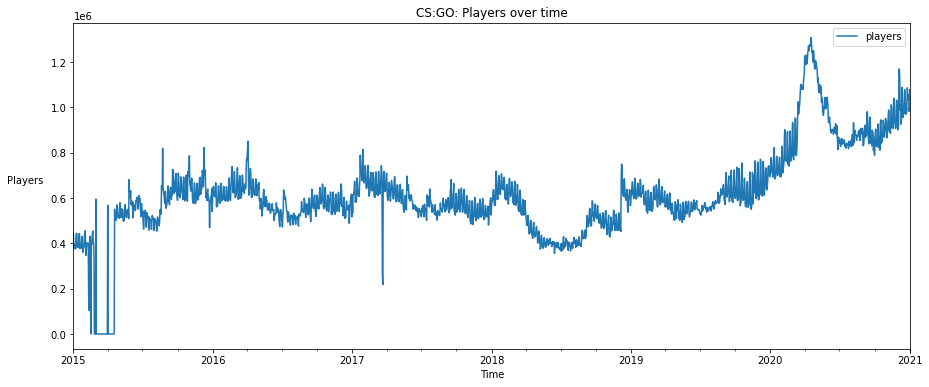

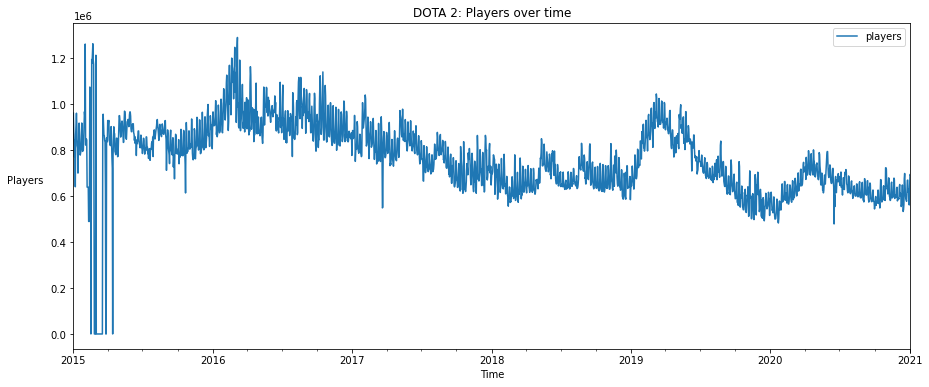

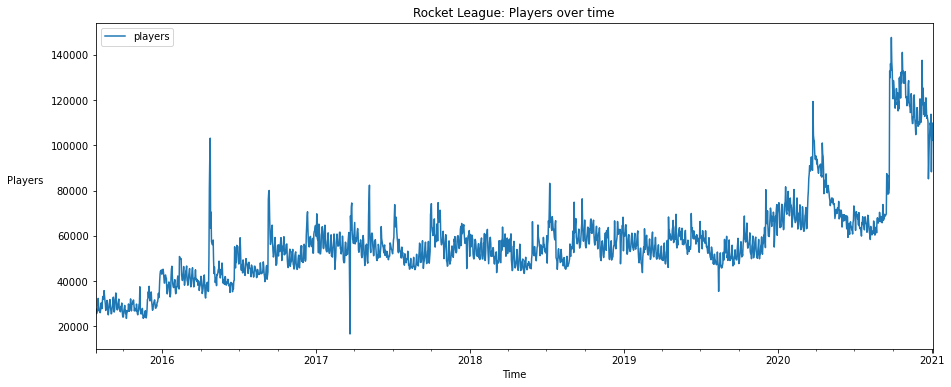

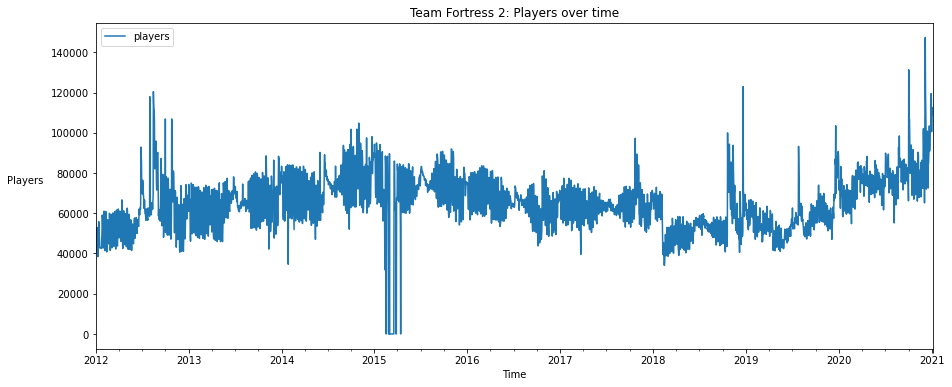

In [5]:
# we need to transform data before we even decide on our predictor column. Let's inspect players over time first. 


for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()
    
    

In [6]:
# we handle discontinuities

for df in ls:
    df['players'] = df['players'].replace(to_replace = 0, method = 'bfill')

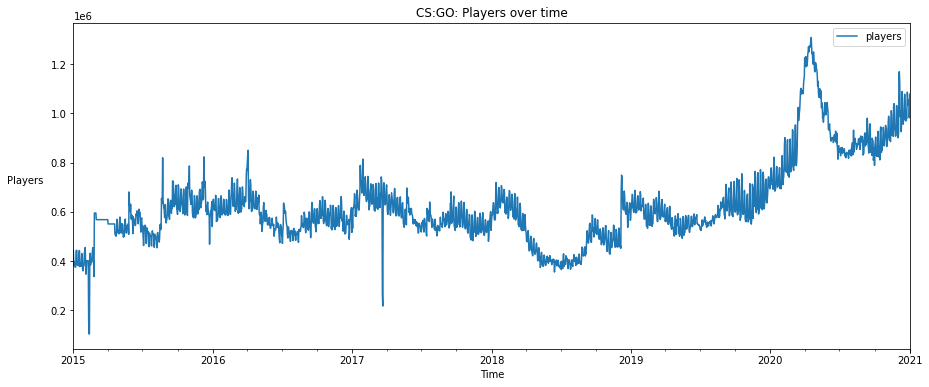

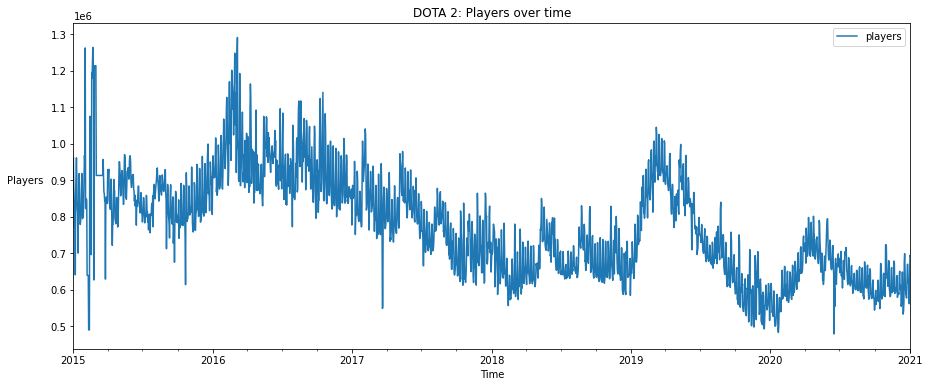

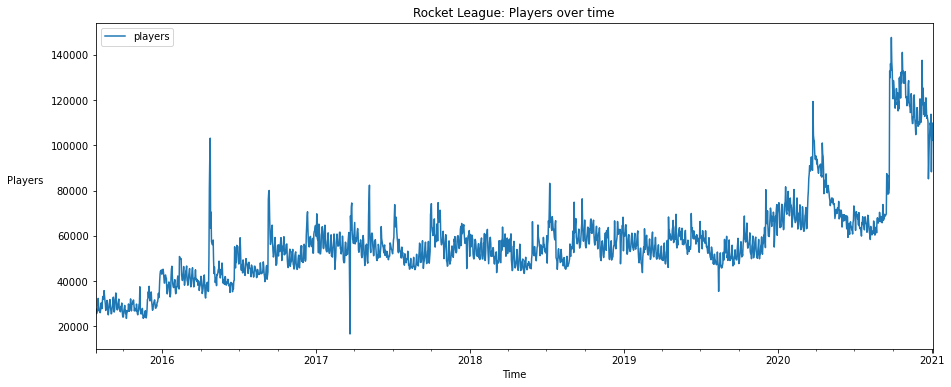

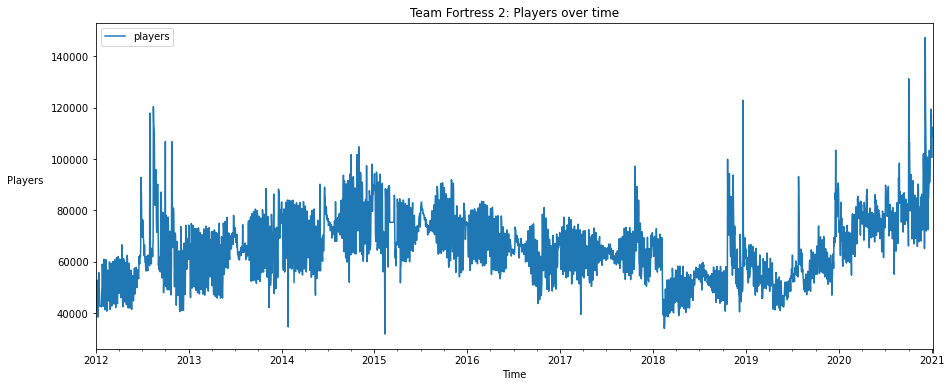

In [7]:
# and inspect to ensure this was successful

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

In [8]:
# all of these games had major changes in number of players directly after their release, leading us to 
# model only player data a sufficient time after release. 

start_dates = [ "2016-01-01",
              "2016-01-01",
              "2016-01-01",
              "2013-01-01"]

trimmed_df_list = []

for i in range(0, 4):
    trimmed = ls[i][start_dates[i]:]
    trimmed_df_list.append(trimmed)
    
ls_trimmed = trimmed_df_list
ls = trimmed_df_list    

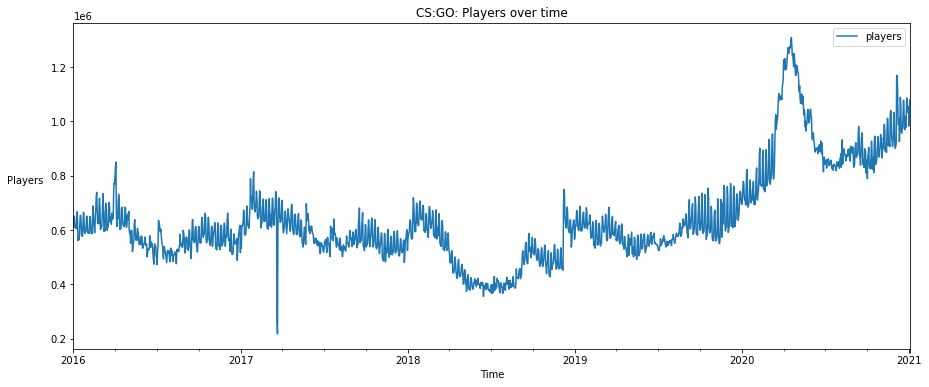

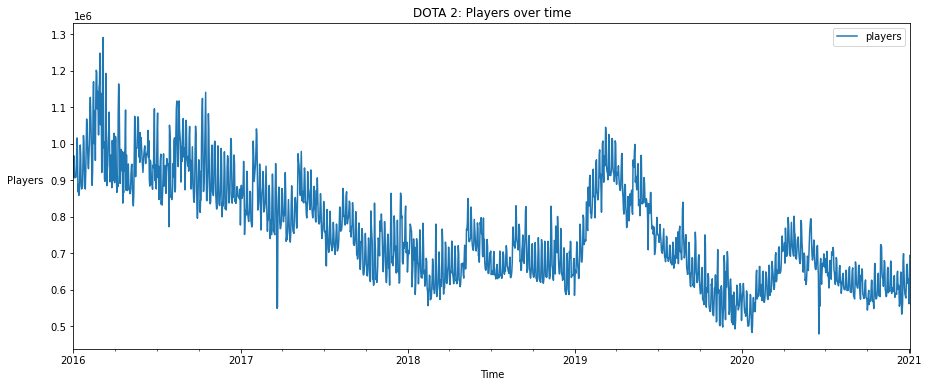

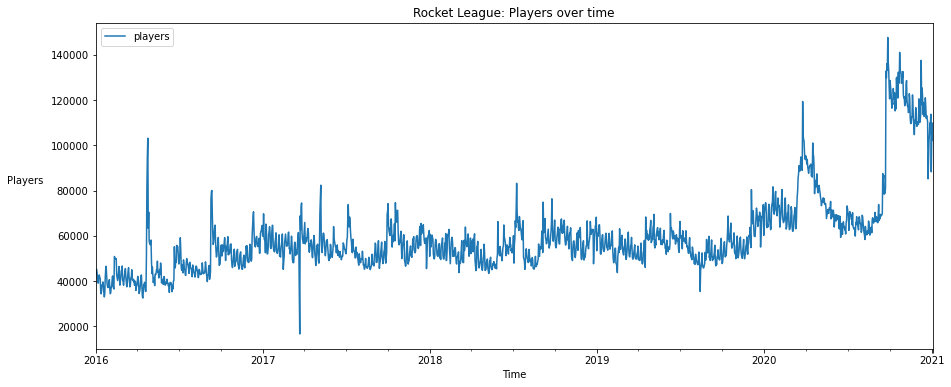

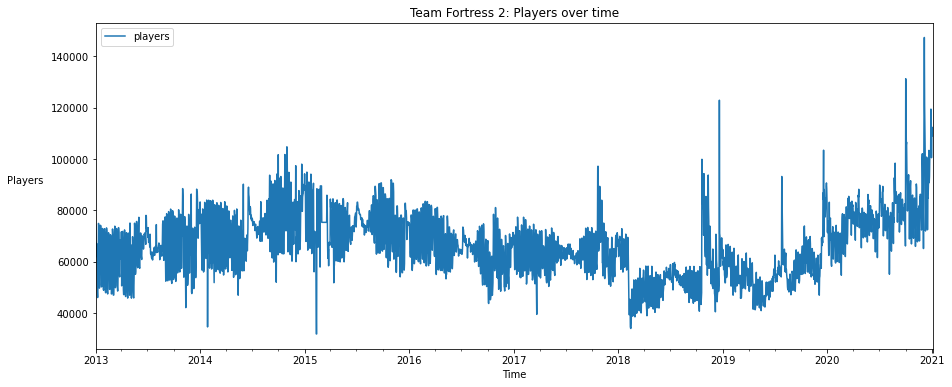

In [9]:
# we inspect our trimmed data

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

Looking much better, but we have more work to complete before this can be modelled. 
#### Stationarity

While we can visualize and approximate if our data is stationary or not, we can also complete an AD Fuller test, or Augmented Dickey-Fuller, to give us a metric of stationarity. 

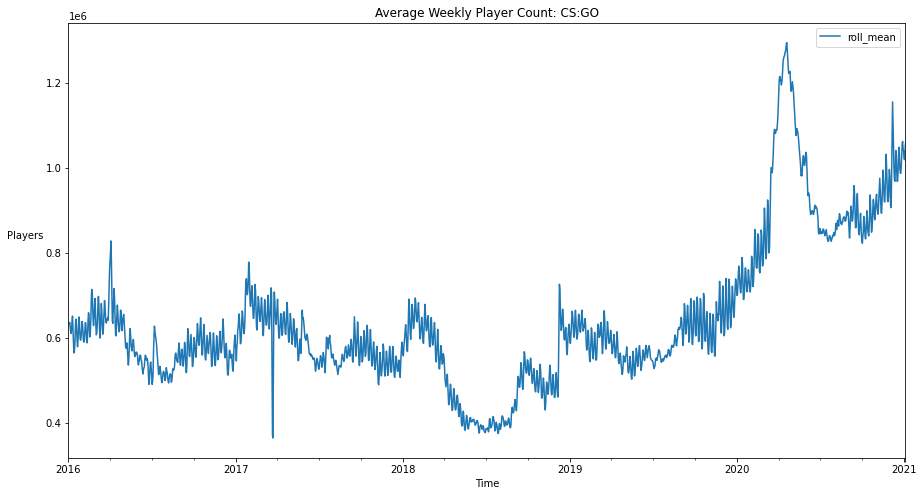

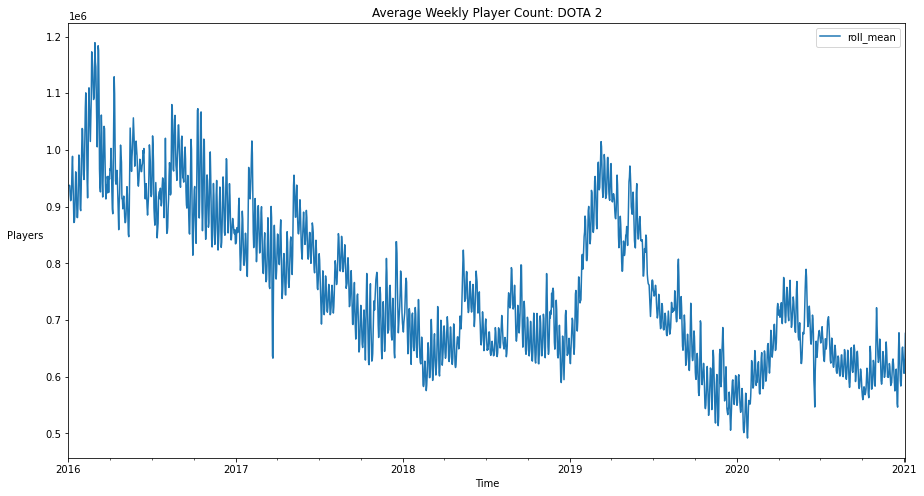

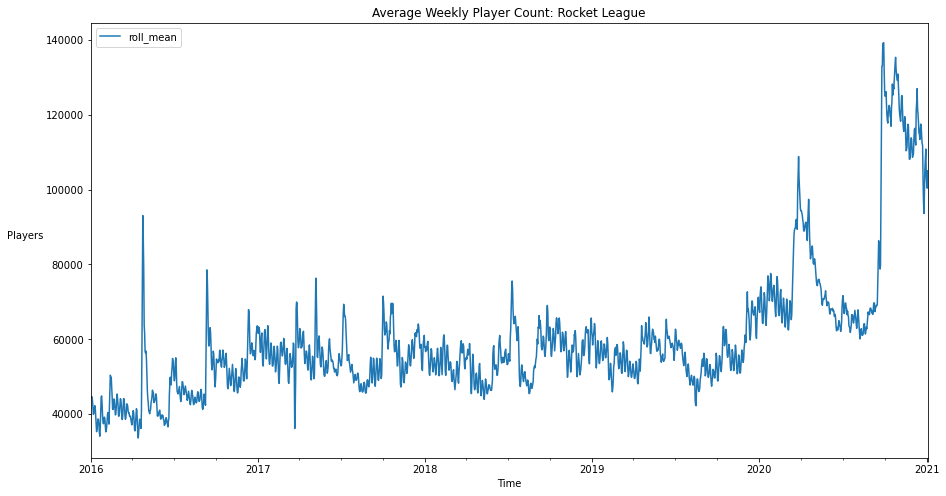

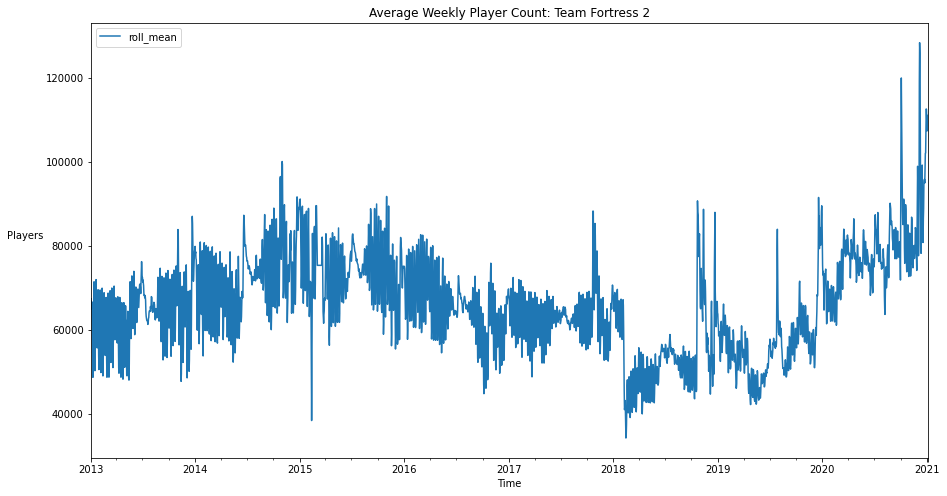

In [10]:
# we visualize our mean player count over time. If this plot has a trend, our data is not stationary. 

for i, df in enumerate(ls):
    
    df['roll_mean'] = df['players'].rolling(window = 3).mean()
    
    df.plot(y = 'roll_mean', title = 'Average Weekly Player Count: '+ labels[i], xlabel = 'Time', figsize = (15, 8))
    plt.ylabel("Players", rotation = 0, labelpad = 20)

In [11]:
# we complete AD Fuller tests for our dataframes. 

for i, df in enumerate(ls):
    result = adfuller(df['players'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -1.100558
p-value: 0.714849
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -1.979913
p-value: 0.295449
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -1.891631
p-value: 0.336009
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -2.268343
p-value: 0.182381
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567



Interestingly, our AD Fuller test shows that Team Fortress 2 data may be stationary. By the above visualization, however, we can see that this is not the case. 

None of our games have stationary data, and we can address this in multiple ways. We can complete data transformations such as log transformations, rolling mean transformations, or differencing.

#### Log Tranformation

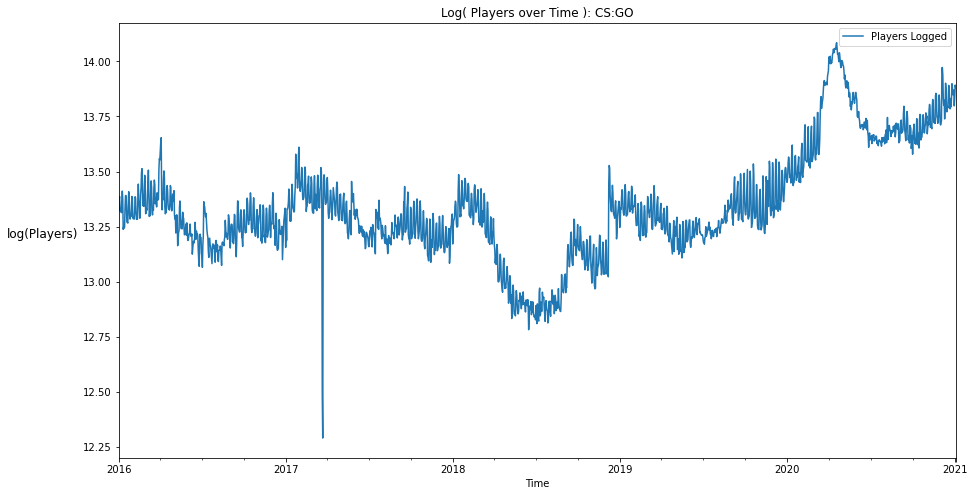

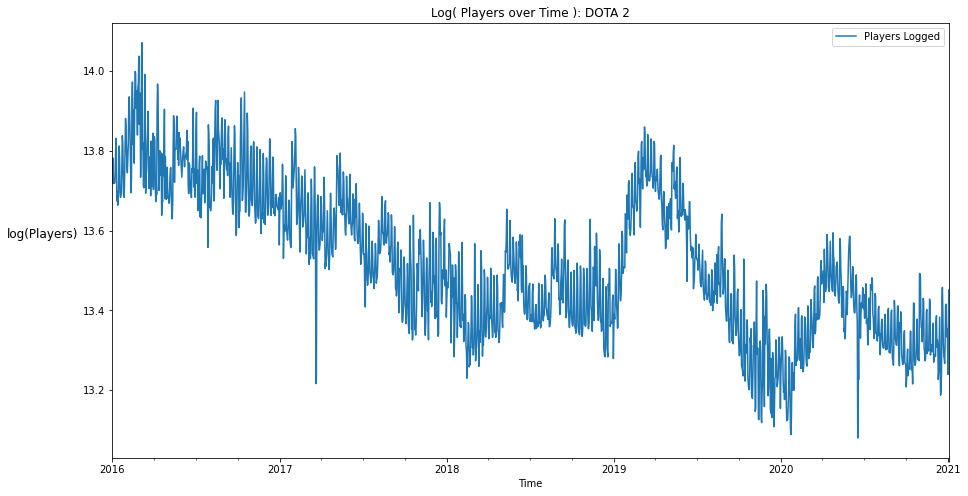

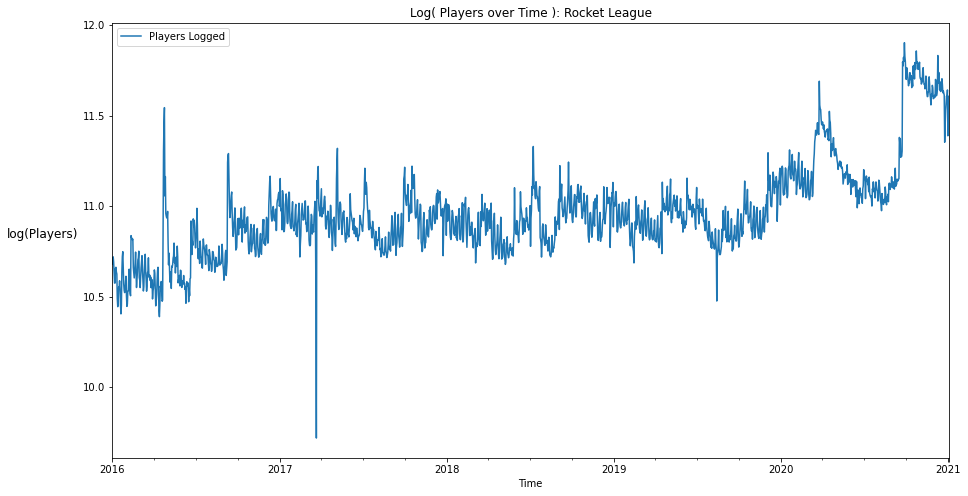

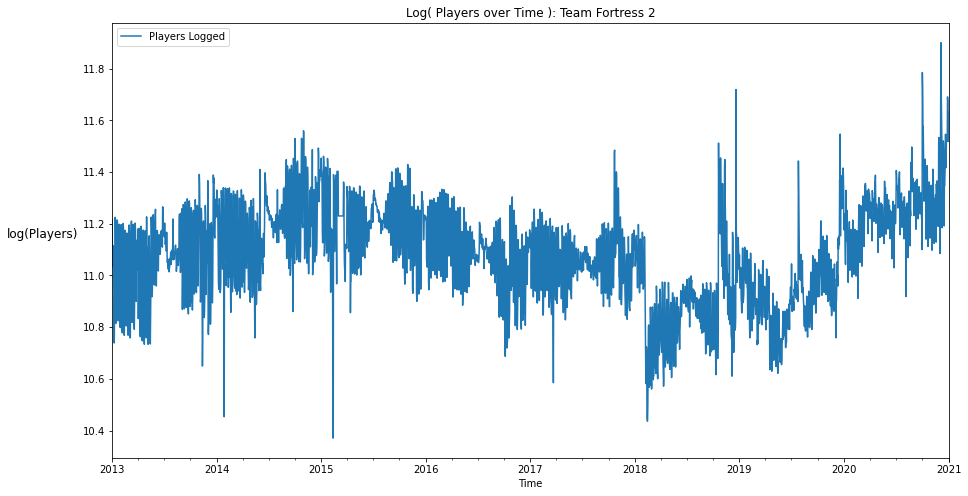

In [12]:
for i, df in enumerate(ls):
    df['players_logged'] = np.log(df['players'])
    
    df.plot(y = 'players_logged', title = 'Log( Players over Time ): '+ labels[i], figsize = (15, 8),
           xlabel = 'Time', label = "Players Logged")
    plt.ylabel('log(Players)', rotation =0 , labelpad = 40, fontsize = 12)
    plt.legend()
    plt.show()

In [13]:
# ADF testing for logged data
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_logged'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -0.904982
p-value: 0.786327
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -2.021767
p-value: 0.277111
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -2.091429
p-value: 0.247975
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -2.264076
p-value: 0.183816
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



#### Rolling Mean Transformations

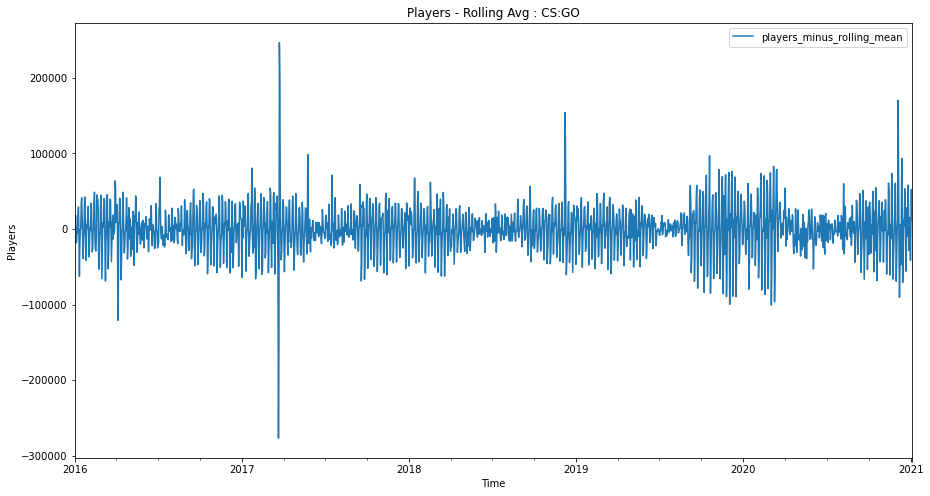

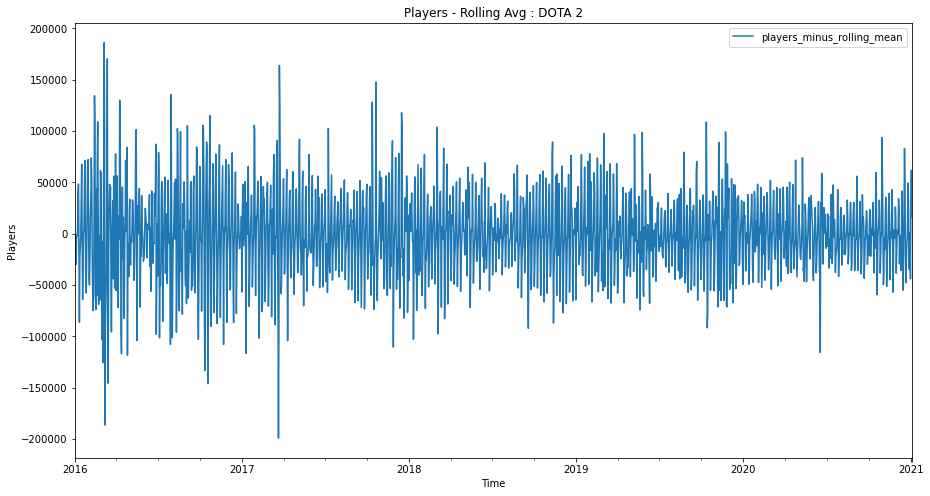

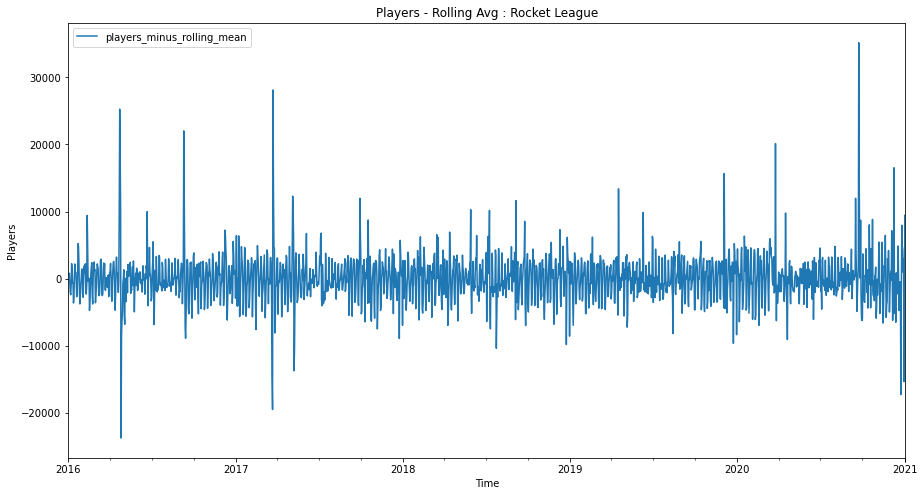

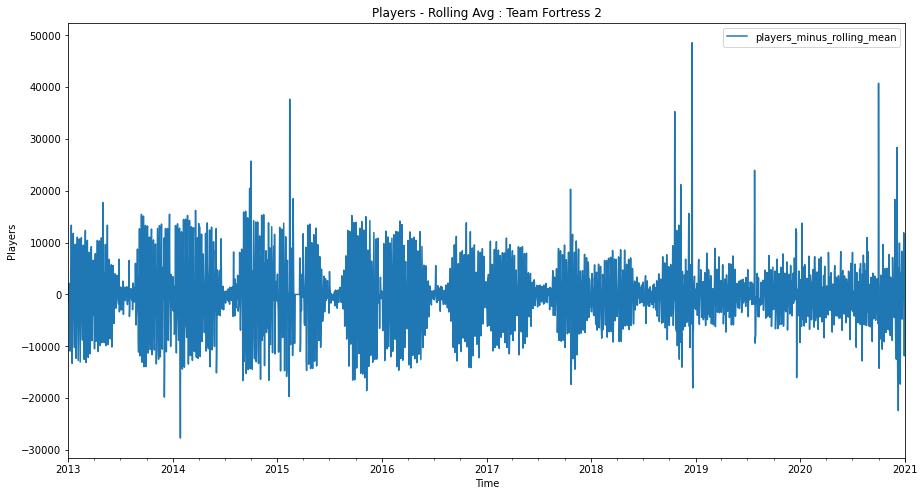

In [14]:
# we can stationize our data by subtracting the rolling mean from our 'players' column. This will force our data to be centered
# on the mean, even if the mean changes over time. 

for i, df in enumerate(ls):
    df['players_minus_rolling_mean'] = df['players'] - df['roll_mean']
    df.plot(y = 'players_minus_rolling_mean', title = "Players - Rolling Avg : "+ labels[i], figsize = (15, 8),
           xlabel = 'Time')
    plt.ylabel('Players')
    plt.show()

In [15]:
# ADF Test for Rolling Mean Transformed data

for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_minus_rolling_mean'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -7.717482
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -10.006815
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -10.527083
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -11.862384
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



The data looks beautifully stationary now, though there are severe outliers in some cases. We'll address this after checking how differencing will make our data look.
#### Differencing

We have already constructed a column that represents a differencing technique. Our '%chg_players' represents this difference in the form of a percentage, but let's construct the raw difference for each games player counts. 

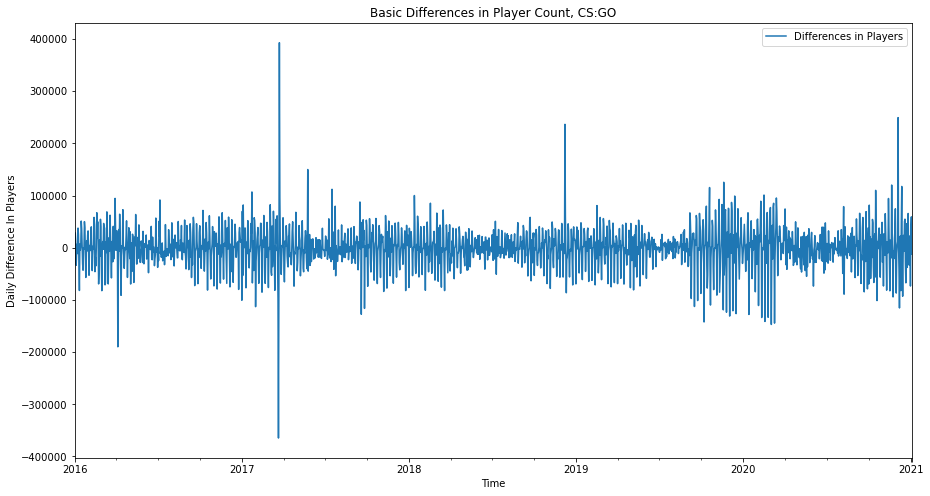

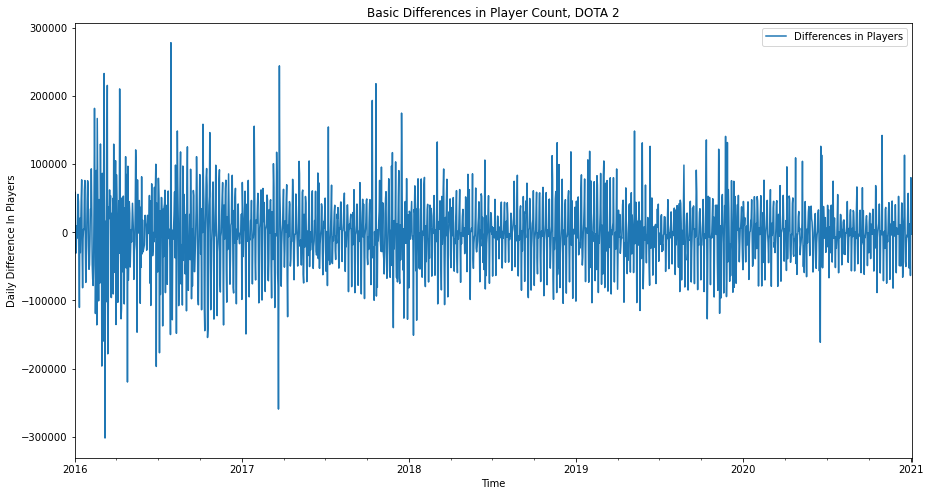

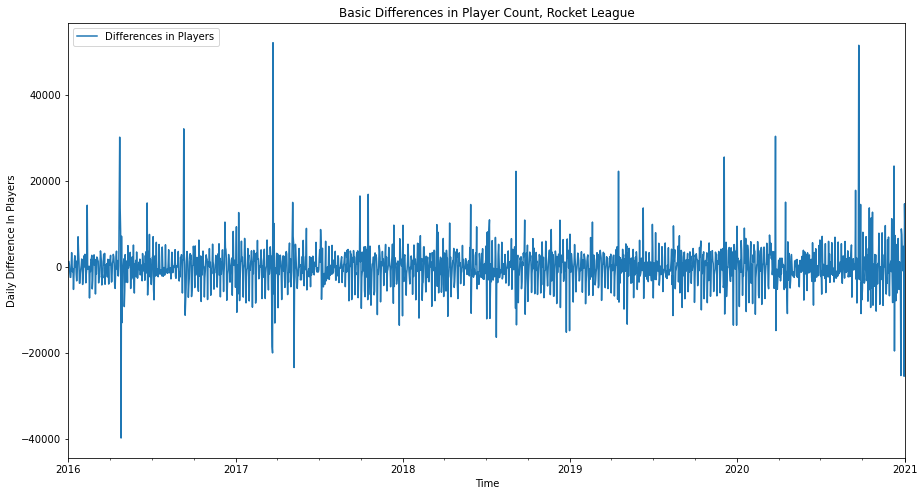

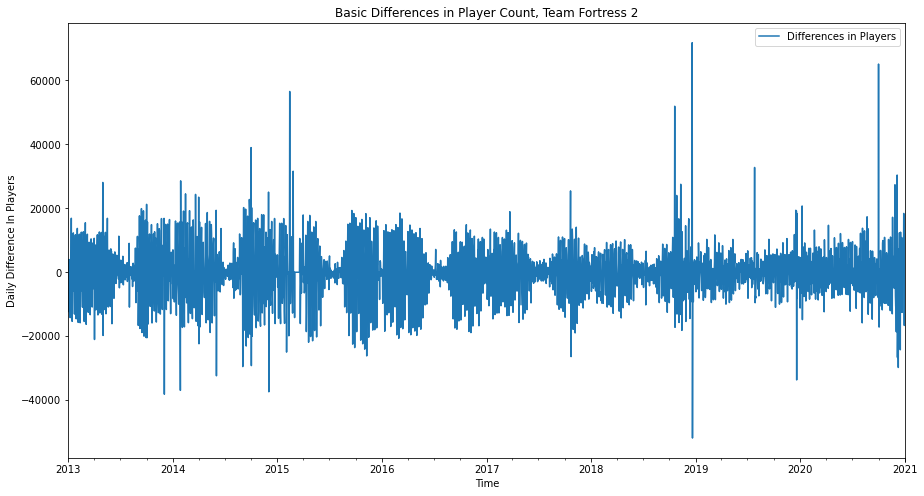

In [16]:
# basic differences

for i, df in enumerate(ls):
    df['difference'] = df['players'].diff(periods = 1)

    df.plot(y = 'difference', title = "Basic Differences in Player Count, "+ labels[i],
            label = 'Differences in Players', figsize = (15, 8), xlabel = 'Time', 
            ylabel = "Daily Difference In Players")
    plt.legend()
    plt.show()

In [17]:


for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['difference'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -8.654211
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -10.874767
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -10.934633
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -12.070897
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



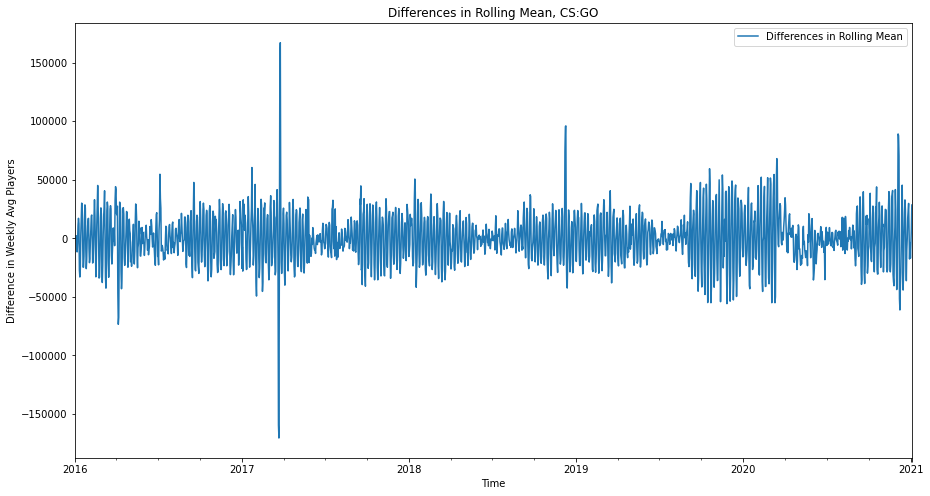

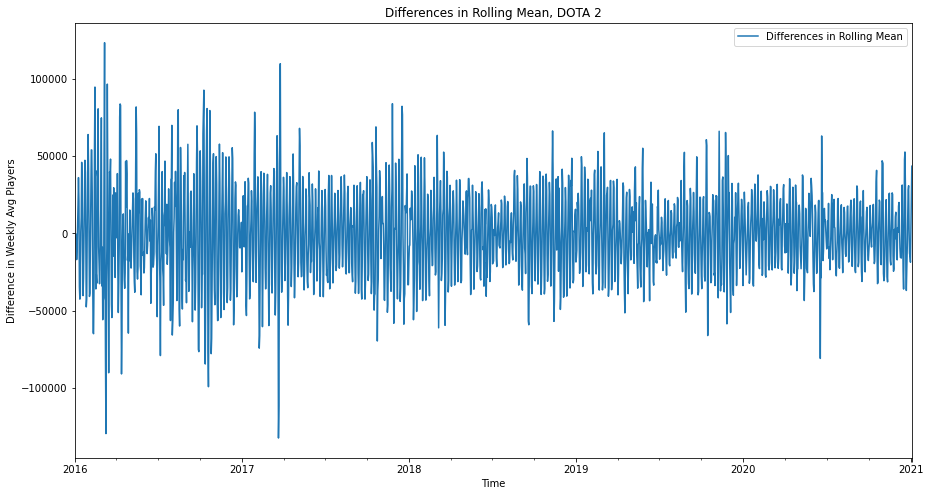

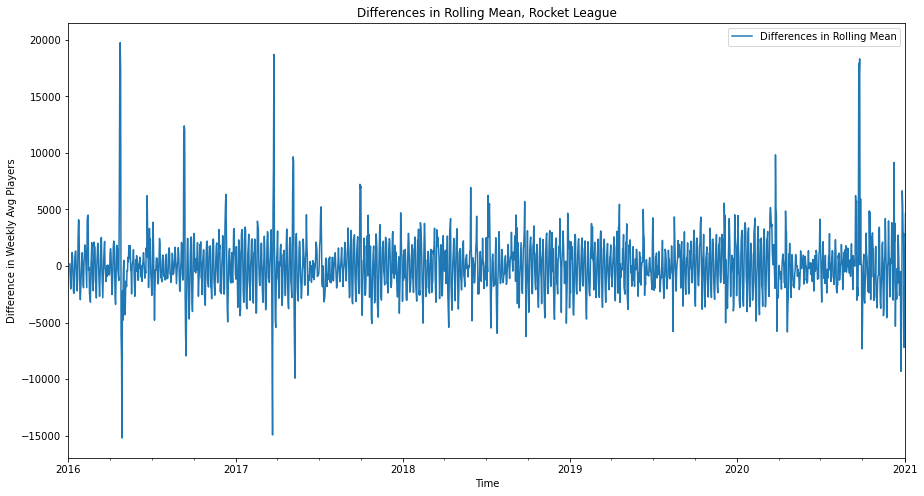

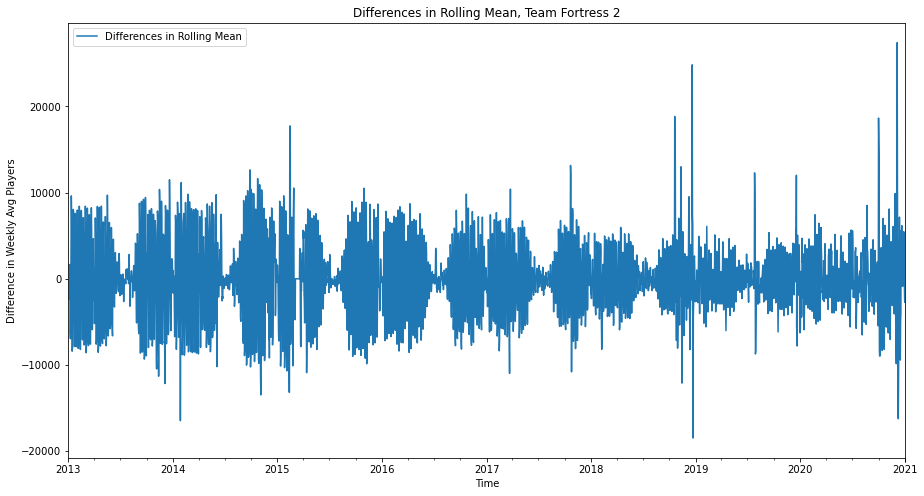

In [18]:
# differences of the rolling mean, though this would affect model interpretability

for i, df in enumerate(ls):
    df['rolling_mean_diff'] = df['roll_mean'].diff(periods = 1)
    
    df.plot(y = 'rolling_mean_diff', xlabel = 'Time', ylabel = 'Difference in Weekly Avg Players', label = 'Differences in Rolling Mean', figsize = (15,8),
           title = 'Differences in Rolling Mean, '+ labels[i])
    plt.legend()
    plt.show()


In [19]:
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['rolling_mean_diff'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -6.669552
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -9.070268
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -9.100540
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -10.318498
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



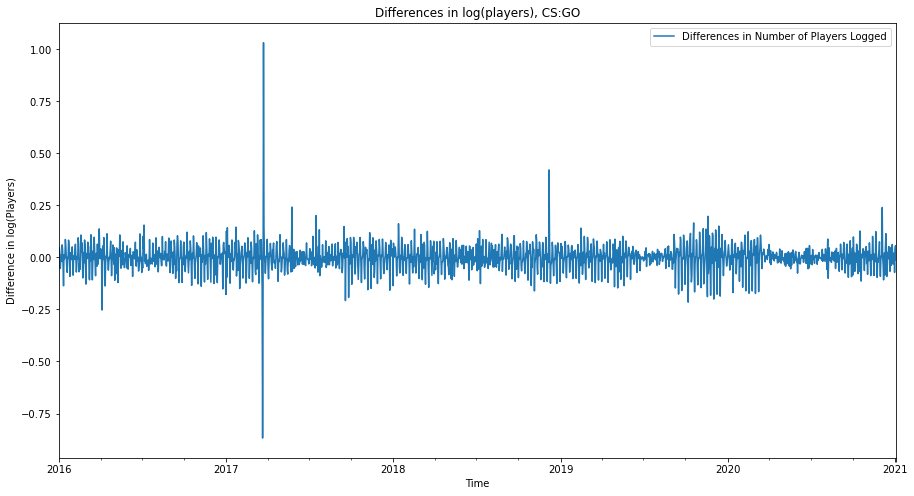

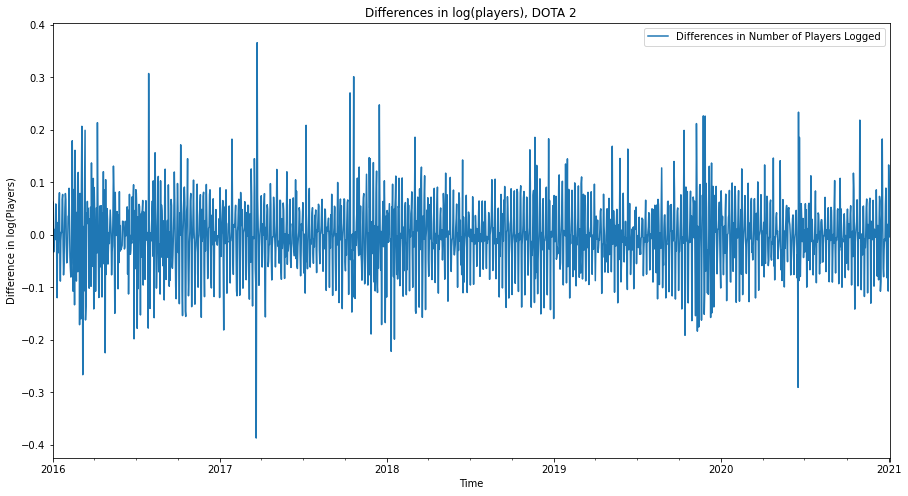

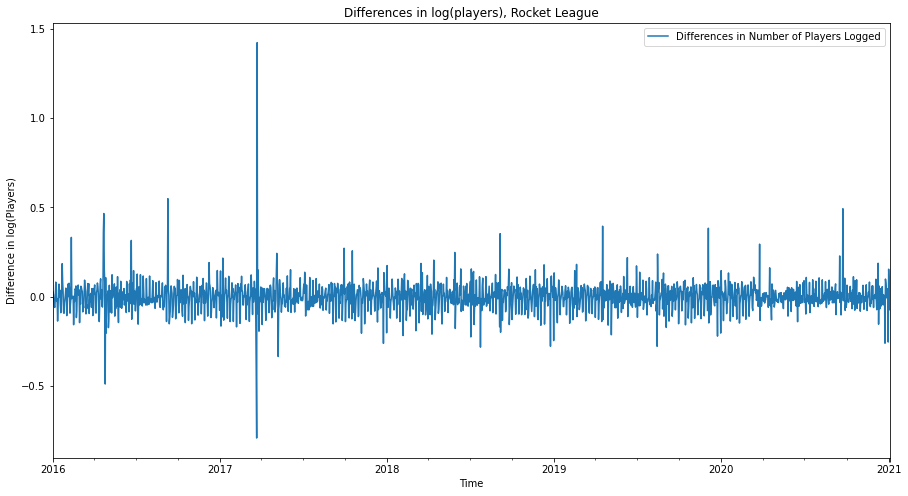

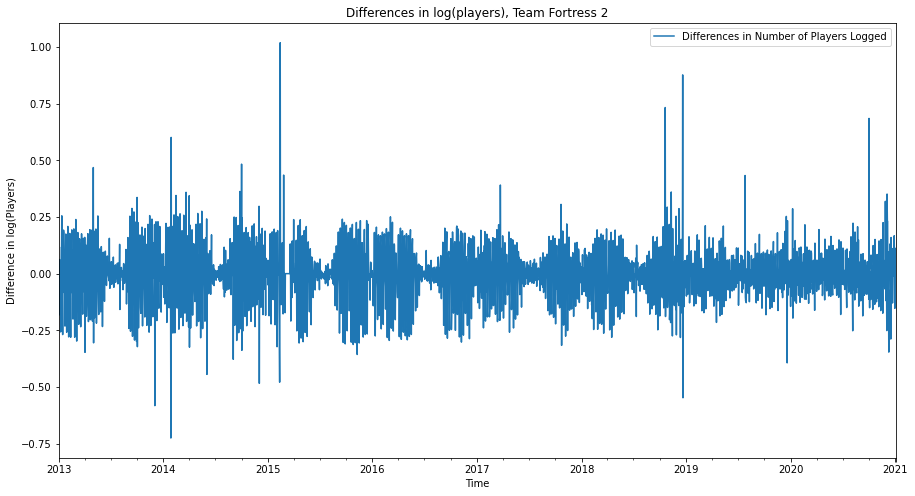

In [20]:
# differences in logged data

for i, df in enumerate(ls):
    df['players_logged_diff'] = df['players_logged'].diff(periods = 1)
    df.plot(y = 'players_logged_diff', title = 'Differences in log(players), '+labels[i], label = 'Differences in Number of Players Logged', figsize = (15, 8),
           xlabel = 'Time', ylabel = 'Difference in log(Players)')

In [21]:
for i, df in enumerate(ls):
    
    df = df.dropna()
    result = adfuller(df['players_logged_diff'])
    print("ADF Test : "+ labels[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('')

ADF Test : CS:GO
ADF Statistic: -10.157618
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : DOTA 2
ADF Statistic: -9.980158
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Rocket League
ADF Statistic: -11.476221
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

ADF Test : Team Fortress 2
ADF Statistic: -11.784883
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



Great! Our visualizations suggest well stationized data, and we verified this through our ADF testing. We are ready to prepare our data for modelling through outlier removal, the final step. 

#### Outliers

We are going to deal with extreme outliers only, and we will continue on with using Logged Data, as this is normalized, on a small scale, and easily transformed back to player count.

In [22]:
# we need to keep a list of dataframes with outliers to use as a testing space.

ls_w_outliers = ls

In [23]:
ls = list(map(lambda df: df.dropna(), ls))

In [24]:
# outliers for our 'players_logged_differences'

# we replace outliers with the preceding non-outlier value

plotting_lists = []

for df in ls:
    outlier_removed = []
    Inter_qr = scipy.stats.iqr(df['players_logged_diff'])
    mean = df['players_logged_diff'].mean()
    Q1 = df['players_logged_diff'].quantile([0.25])[0.25]
    Q3 = df['players_logged_diff'].quantile([0.75])[0.75]
    upper = Q3 + 3*Inter_qr
    lower = Q1 - 3*Inter_qr
    print(lower, upper)
    for i, val in enumerate(df['players_logged_diff']):
        if val > upper:
            df['players_logged_diff'][i] = df['players_logged_diff'][i-1]
        elif val < lower:
            df['players_logged_diff'][i] = df['players_logged_diff'][i-1]
        else:
            continue


-0.19719134797564752 0.2014688531098061
-0.254719751483802 0.2648006319631122
-0.26011755209674803 0.2665679191113206
-0.32827209527797674 0.3356595500556514


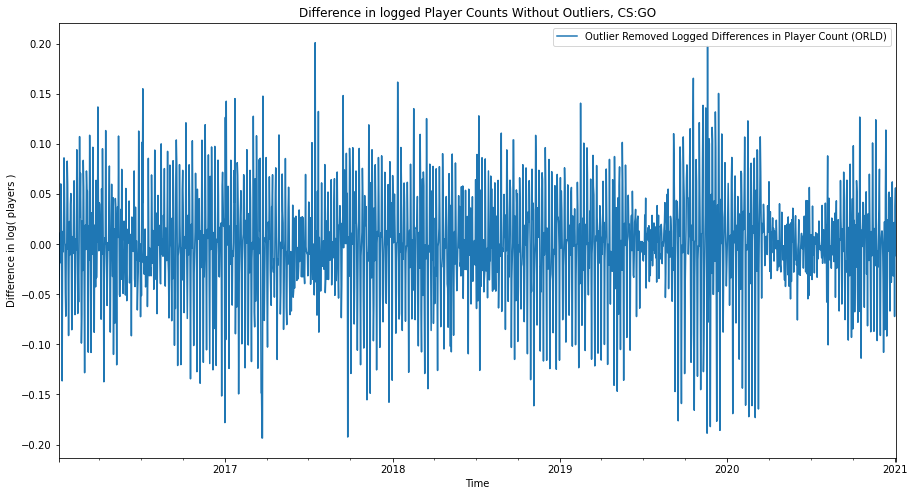

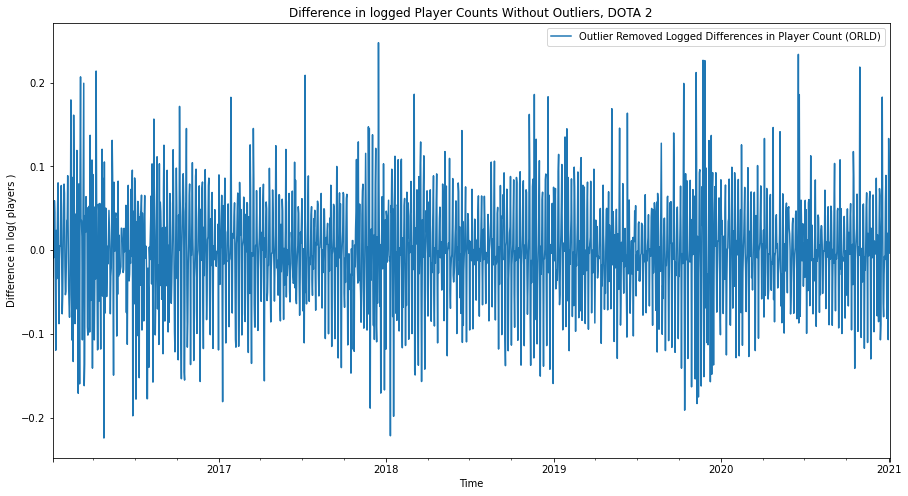

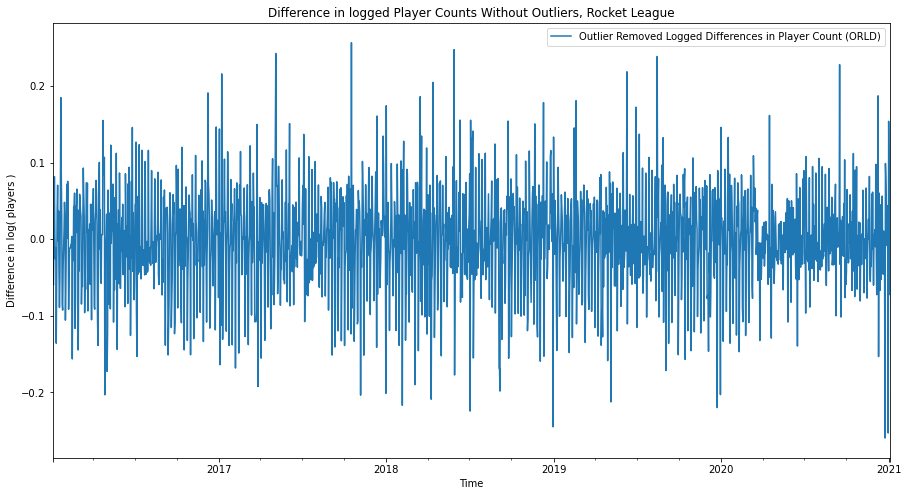

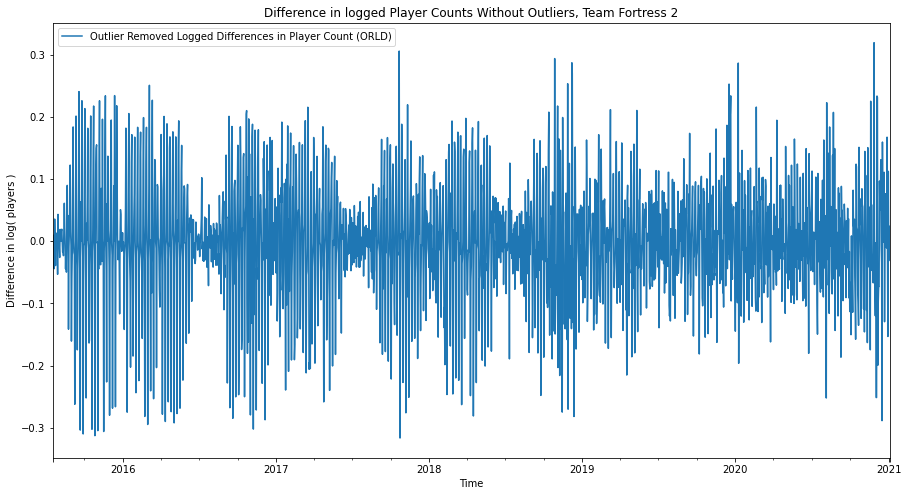

In [25]:
# let's see how this affected our data

for i, df in enumerate(ls):
    
    df.plot(y='players_logged_diff',label = "Outlier Removed Logged Differences in Player Count (ORLD)", figsize = (15, 8),
           xlabel = 'Time', ylabel = "Difference in log( players )", title = "Difference in logged Player Counts Without Outliers, "+ labels[i])
    plt.legend()
    plt.show()

We have beautifully stationary data, without outliers, and this is also very easy to return to our original player count!

This data is ready to be modelled. 

In [26]:
ls_prepped = ls

### b. Model Construction

We will be using a gridsearch to find the optimal model. However, we still have to manually find S, or the seasonal component of the model. 

In [27]:
# we define our predictor column and prepare it.

mod_ls = []

for df in ls_prepped:
    df_mod = pd.DataFrame()
    df_mod['ORLD'] = df['players_logged_diff']
    mod_ls.append(df_mod)
    
training_ls = mod_ls

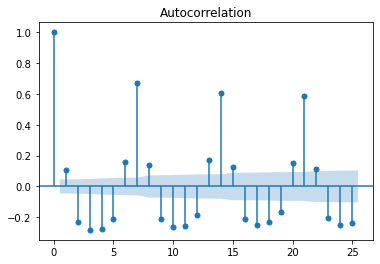

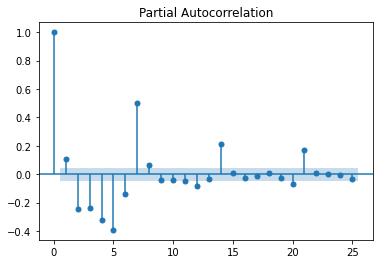

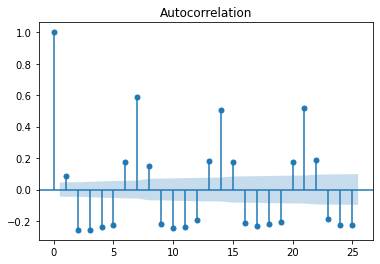

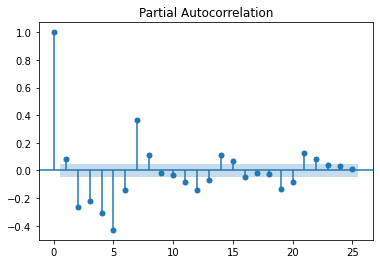

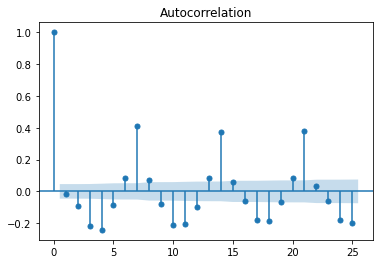

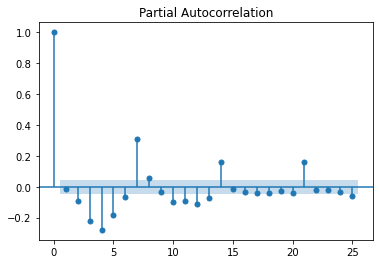

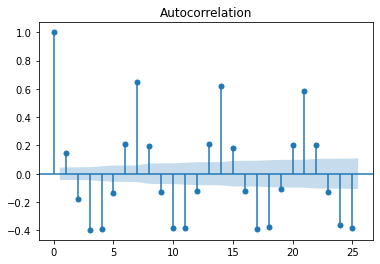

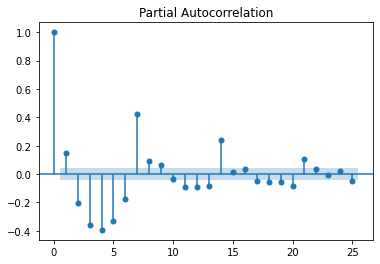

In [28]:
# we plot both ACF and PACF

for df in mod_ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)

The above plots suggest that our seasonal period for all our games is 7 days, or one week. 

In [30]:
# we establish our parameter variables

p = q = range(0, 3)
d = [0]
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]




In [31]:
# performing the gridsearch


ans_ls = []
for df in mod_ls:
    df = df.dropna()
    ans = []
    for comb in pdq:
        for combs in pdqs:
            mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5412.14552460485
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6157.1366785778355


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-4260.41896052099
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6481.827497667089


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6454.6105908496675
ARIMA (0, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-5112.05624122583


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-6612.332402102563
ARIMA (0, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-6574.180191229934


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-5519.518456524214
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4354.783496208123


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4688.440452275536
ARIMA (0, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2790.1782550037237


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5107.1896414936655
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5002.458613328386
ARIMA (0, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3632.413392576528

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5208.878188999257


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5160.344572235019


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4062.5406025910374
ARIMA (0, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2597.4660250367965


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2654.305931054435
ARIMA (0, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-756.3120599228864


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3154.9405025399337


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2989.950535462396
ARIMA (0, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1605.260068156012
ARIMA (0, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3239.523777311836


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3173.6540916696085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2052.968491781775
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5432.191791716542


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6181.275547545603


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-4287.530415002247


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6492.079831254158


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6472.77087573123


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-5138.436691560424


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-6621.297266244932


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-6583.438359529795
ARIMA (1, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-5540.453755407543
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4534.841789318491


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5283.279301658406
ARIMA (1, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-3404.5606378588036
ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5593.268999978377


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5567.2654083588695


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-4239.798674195421
ARIMA (1, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5718.054420697183


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5680.8234147704625


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4642.78282925665
ARIMA (1, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3267.403732137278


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3776.6165653753324
ARIMA (1, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1890.64696938507


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4145.740266620858


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4083.713679873393


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2735.8359407136177


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4262.911261592457
ARIMA (1, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4222.4924104592465


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3165.42099932964
ARIMA (2, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5541.229656471298


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6183.686612536254
ARIMA (2, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-4289.748763985096


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6501.6441003924465


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6482.161446262795


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-5142.766750280562


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-6634.51789582407


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-6593.097971519801


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-5545.36381505243
ARIMA (2, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4685.230071085997

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (2, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5531.6338629890615


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (2, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-3664.1886141106675
ARIMA (2, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5808.804059977514


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5801.8973073745965


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-4492.95361028377


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5938.497258200508


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5903.5645494986775


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4875.590423626503
ARIMA (2, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3653.726921221636

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (2, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4331.583322049862


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2453.478340754849
ARIMA (2, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4650.934155716781


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4624.283094947426


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3303.759636552524


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4778.6941003370985


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4738.8763254928945
ARIMA (2, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3700.1658167257674
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4796.382186622223
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5136.479722235471

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (0, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-3242.9199740163085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5550.476148472426
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5434.033770267652

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-4042.757167386342


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5641.515744767446
ARIMA (0, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5613.926450359674


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4485.327178812424
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3689.8098354910862


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3554.8623675643985
ARIMA (0, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1669.951878670559


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4115.58513226393
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3856.8685044110534


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2478.9110146595353
ARIMA (0, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4158.567310594333


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4033.886227564197


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2905.100907379112
ARIMA (0, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-1925.5387474758538


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-1501.993448592856
ARIMA (0, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =377.6095492005745


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-2183.113912664412
ARIMA (0, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-1816.3294379614726


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-442.11909760252513
ARIMA (0, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-2201.995887211696


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-2003.8819292419082


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-875.7555999423676
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4807.594504845085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5202.08061928427


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-3307.8201647757355


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5576.823449651132


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5495.6310835322165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-4102.404738553074


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5678.51078158824


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5679.457343371205


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4555.478293999806
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3876.670481479713


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4193.984891755679


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2316.1780126049425
ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4591.997682374489


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4476.851317479406


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3109.8852229547674


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4678.39679335714


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4646.064452448709


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3532.7014973351725
ARIMA (1, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2576.1084389762436


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2650.4113248370977
ARIMA (1, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-781.3784685611957


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3129.035903966085


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2938.7873824831095


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1574.0513169725668


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3191.0211755520127


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3118.5037878080807


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2006.9070365850087
ARIMA (2, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4935.516799248009


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5224.454585307883


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-3327.230441240037


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5607.707367540235


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5524.413670377462


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-4123.600262556454


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5709.981000585562


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5716.6196419945145


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4586.704341457025
ARIMA (2, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4063.3577216466747


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (2, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4481.19259496505
ARIMA (2, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2598.599079004226


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4833.080379370182


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4769.3496860709565


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3402.9566210554317


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4941.73193244962


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4932.790095194533


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3818.189627480756
ARIMA (2, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3000.249177971394


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3206.2098534295883


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1323.2180959309576


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3626.7778302272145
ARIMA (2, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3508.574387838142


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2145.790402110842
ARIMA (2, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3718.721380594737


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3675.353964143244


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2562.0796847838383
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4754.132015857273


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4459.866703657828
ARIMA (0, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2481.9502587671996


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5079.708360905179
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4897.231798074956


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3466.322853658557


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5176.218635251489


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5078.675000580618


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3981.493658443869
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3457.2529115840534
ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2936.8712319618844

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (0, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-954.8197330527192
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3656.551427359753


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3397.962260641637


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1953.9921514628757
ARIMA (0, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3728.5198983661558


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3598.3311728611466


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2482.264122948587
ARIMA (0, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-1497.4080478339124
ARIMA (0, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-866.9192176522629


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =1109.597277624376
ARIMA (0, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-1646.3478447293078


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-1339.9107952135682


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =108.10593057915898


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-1706.1177131974625
ARIMA (0, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-1560.1758187096793


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-429.56195470895625
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4752.596645440336


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4501.854426762988


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2527.9619177514105
ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5092.606708467225


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4928.542256172412


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3505.344799834762


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5195.455441606322


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5106.480188659487


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4017.1491175520287
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3895.014285611406


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3621.21625816012
ARIMA (1, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1644.5214214053187


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4224.581706538147


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4062.838380274872


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2649.0600114652348
ARIMA (1, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4330.558608211609


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4233.106519941215


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3170.445024234099
ARIMA (1, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2567.032707158673


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2061.717389185069
ARIMA (1, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-74.91530977948193
ARIMA (1, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-2774.36665780256


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2539.6567462230405


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1109.8883202293364
ARIMA (1, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-2859.2537303001013


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-2729.501166320907


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-1653.1304811498894
ARIMA (2, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4763.178901147401


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (2, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4500.347434102672
ARIMA (2, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2527.72215201921


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5095.9422942707315


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4924.982384176218


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3501.6250257811894


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5193.740556516099


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5104.656858445507


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-4013.17475674857
ARIMA (2, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4000.3860772877897


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3917.8577470920645
ARIMA (2, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1964.375910425776


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4435.909204204225


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4318.6350983416


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2924.764491617313


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4552.620434516785


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4479.889956449402


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3424.762994643634
ARIMA (2, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2985.63149496429
ARIMA (2, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2725.233051658449

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-764.8829112099385
ARIMA (2, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3322.7571283201974


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3153.4361091245414


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1750.970069912311


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3424.363726699847


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3326.1515559764885


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2269.583975466838
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3707.3466550307103


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4405.831769404199
ARIMA (0, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2266.2639937000727


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4785.424237157192
ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4853.529440269402

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3384.3272373588006


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5011.03177492519


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4960.013064880052


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3795.4136964840877
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2635.3398933253693


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2730.972371662041
ARIMA (0, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-581.485041035308


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3264.3192815398215
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3216.063656919424


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1743.5097511193994


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3443.8035177535744
ARIMA (0, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3329.4481252628334

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2149.397561430371
ARIMA (0, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-709.2309388916626


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-522.3185246871997
ARIMA (0, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =1628.723074574876


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-1153.14588085721
ARIMA (0, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-1033.807961317127


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =436.57612015760554
ARIMA (0, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-1308.7867222045454
ARIMA (0, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-1155.5177186734418

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =24.46379883265368
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3748.2100561158786


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4454.594439822288
ARIMA (1, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2321.4661115163235
ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4799.789229659353


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4887.517886250642


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3422.284652945054


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5031.897635057056


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4993.774449688255


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3837.1646863788997
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2837.0728664110893


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3347.2258982506382
ARIMA (1, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1218.12224534485


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3748.514260226326
ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3787.126229206935


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2325.7676739202584


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-3958.14018833581


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-3897.839613063328


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-2735.0862694229827
ARIMA (1, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-1583.5010131035979


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-1672.480491728264
ARIMA (1, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =454.3834007551911


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-2202.6819336557014


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2126.7011725582265


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-657.2274079220409


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-2362.4233722100967


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-2253.5780527337174


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-1082.8691105688852
ARIMA (2, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3826.3653392899187


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4493.714600223759
ARIMA (2, 0, 0) x (0, 2, 0, 7)12 : AIC Calculated =-2358.3703338102514


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4835.097243909082


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4931.979190026228


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (1, 2, 0, 7)12 : AIC Calculated =-3465.523359224667


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 0, 0, 7)12 : AIC Calculated =-5073.582898774681


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 1, 0, 7)12 : AIC Calculated =-5037.846276453953


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3882.126920894846
ARIMA (2, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-2893.237682049945


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3678.466714558639


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (0, 2, 0, 7)12 : AIC Calculated =-1546.4655540273593


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3994.8729552468008


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4122.886104521984


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (1, 2, 0, 7)12 : AIC Calculated =-2679.714539856668


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 0, 0, 7)12 : AIC Calculated =-4251.911663115511


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 1, 0, 7)12 : AIC Calculated =-4216.035937470206


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) x (2, 2, 0, 7)12 : AIC Calculated =-3067.441110941392
ARIMA (2, 2, 0) x (0, 0, 0, 7)12 : AIC Calculated =-1853.3842910643789
ARIMA (2, 2, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2296.4268831432437


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

ARIMA (2, 2, 0) x (0, 2, 0, 7)12 : AIC Calculated =-161.88933044447165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 0, 0, 7)12 : AIC Calculated =-2713.380832637996


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2760.836659001278


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (1, 2, 0, 7)12 : AIC Calculated =-1315.4197978376033


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 0, 0, 7)12 : AIC Calculated =-2934.670786193399


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 1, 0, 7)12 : AIC Calculated =-2861.147794185237


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) x (2, 2, 0, 7)12 : AIC Calculated =-1695.2176588586888



### c. Model Validation

In [32]:
# we generate validation statistics for our models

csgo_model = SARIMAX(mod_ls[0],
                    order = ans_ls[0].loc['pdq'],
                    seasonal_order = ans_ls[0].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
csgo_output = csgo_model.fit()
(csgo_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood                3322.259
Date:                           Wed, 27 Jan 2021   AIC                          -6634.518
Time:                                   14:15:05   BIC                          -6607.010
Sample:                               01-04-2016   HQIC                         -6624.367
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0983      0.016     -6.142      0.000      -0.130      -0.067
ar.L2         -0.0956      0.018     -5.274      0.000      -0.131      -0.060
ar.S.L7        0.4807      0.016     30.543      0.000       0.450       0.512
ar.S.L14       0.2893      0.016     17.693      0.000       0.257       0.321
sigma2         0.0015   3.08e-05     48.438      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              1372.76
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
dota_model = SARIMAX(mod_ls[1],
                    order = ans_ls[1].loc['pdq'],
                    seasonal_order = ans_ls[1].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
dota_output = dota_model.fit()
print(dota_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 7)   Log Likelihood                2863.310
Date:                           Wed, 27 Jan 2021   AIC                          -5716.620
Time:                                   14:15:06   BIC                          -5689.131
Sample:                               01-04-2016   HQIC                         -5706.474
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2274      0.018    -12.672      0.000      -0.263      -0.192
ar.L2         -0.1518      0.017     -8.810

In [34]:
rl_model = SARIMAX(mod_ls[2],
                    order = ans_ls[2].loc['pdq'],
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
rl_output = rl_model.fit()
print(rl_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                      SARIMAX Results                                      
Dep. Variable:                                ORLD   No. Observations:                 1827
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood                2668.113
Date:                             Wed, 27 Jan 2021   AIC                          -5328.226
Time:                                     14:15:07   BIC                          -5306.218
Sample:                                 01-04-2016   HQIC                         -5320.105
                                      - 01-03-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1134      0.017     -6.626      0.000      -0.147      -0.080
ar.S.L7        0.0831      

In [35]:
tf_model = SARIMAX(mod_ls[3],
                    order = ans_ls[3].loc['pdq'],
                    seasonal_order = ans_ls[3].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
tf_output = tf_model.fit()
print(tf_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                              ORLD   No. Observations:                 1998
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 7)   Log Likelihood                2541.791
Date:                           Wed, 27 Jan 2021   AIC                          -5073.583
Time:                                   14:15:08   BIC                          -5045.624
Sample:                               07-17-2015   HQIC                         -5063.312
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1356      0.017     -8.002      0.000      -0.169      -0.102
ar.L2         -0.1535      0.020     -7.773

In [36]:
models = []
outputs = []
models = [csgo_model, dota_model, rl_model, tf_model]
outputs = [csgo_output, dota_output, rl_output, tf_output]

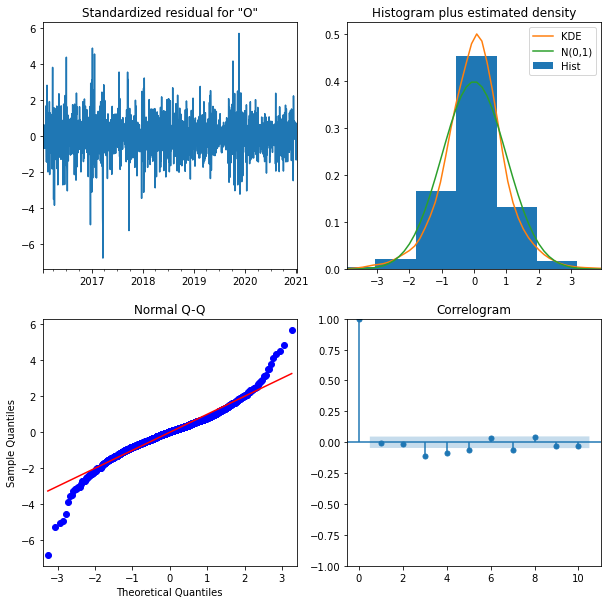

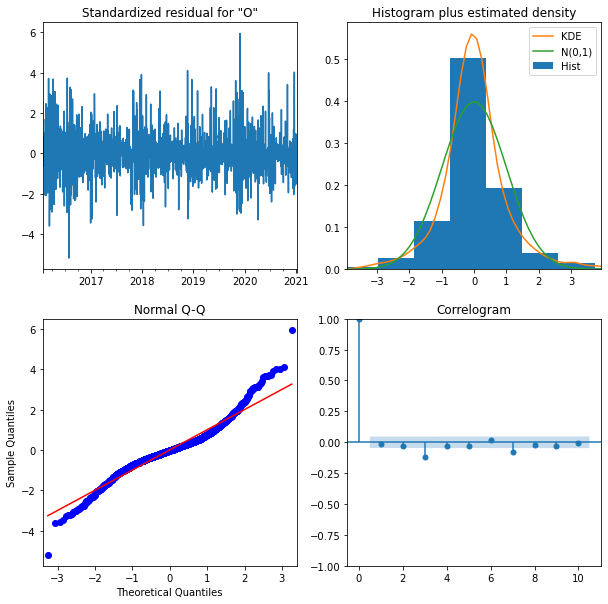

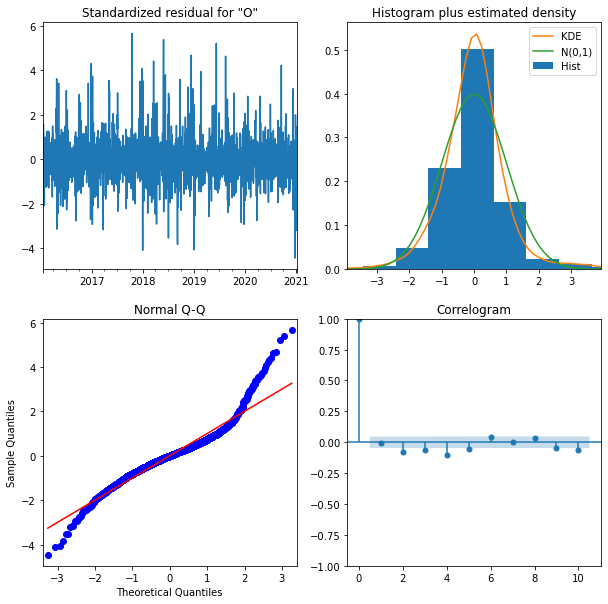

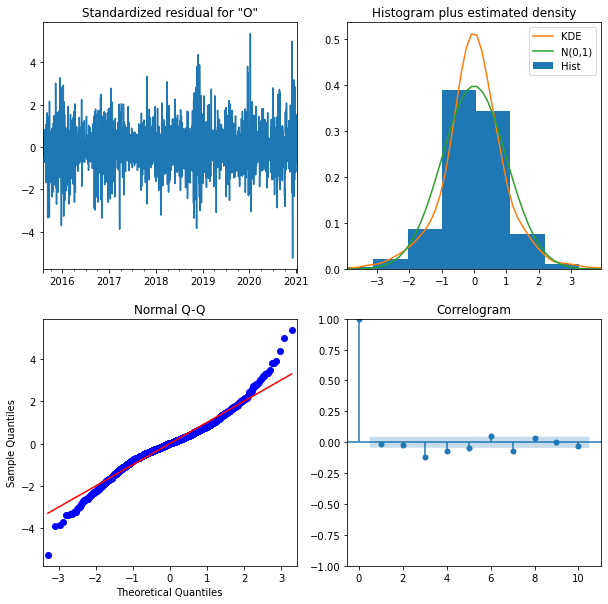

In [37]:
for i, output in enumerate(outputs):
    
    output.plot_diagnostics(figsize = (10, 10))
    

#### Forecasting our Basic Models

We will be forecasting from 2020-12-01 to present, and visualizing the full month.

In [38]:
# we generate our forecasts for each model

predictions = list(map(lambda output: output.get_prediction(start = pd.to_datetime("2020-12-15"), dynamic = False), outputs))
intervals = list(map(lambda prediction: prediction.conf_int(), predictions))

forecasts = list(map(lambda prediction:prediction.predicted_mean.to_frame('predicted_mean'), predictions))


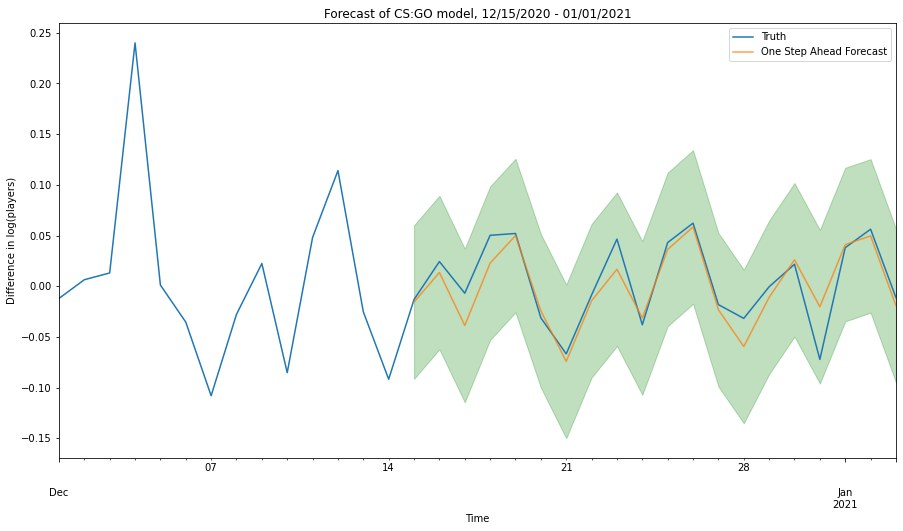

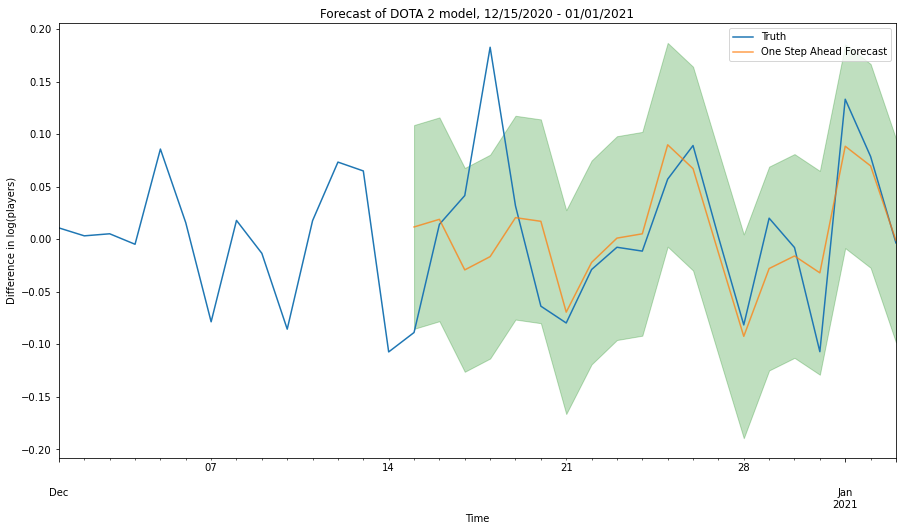

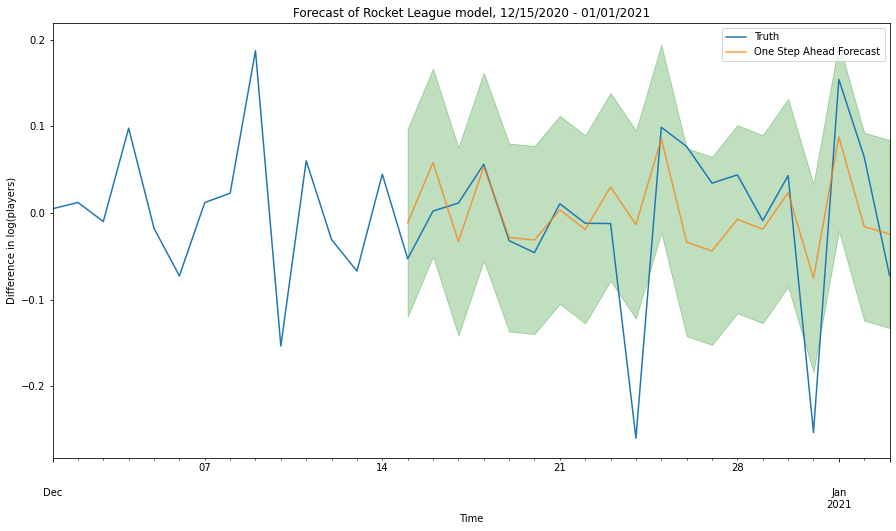

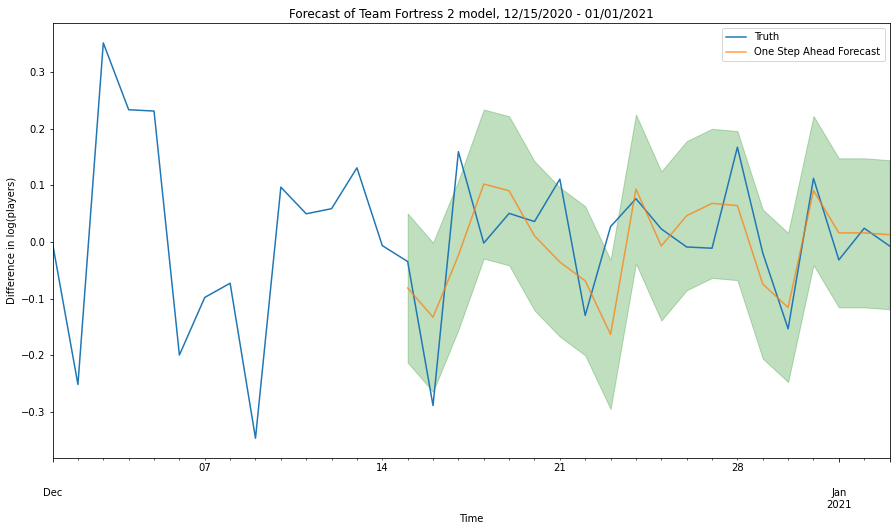

In [39]:

for i, df in enumerate(ls_w_outliers):
    
    ax = df['2020-12-01':].plot(y = 'players_logged_diff', label = 'Truth', figsize = (15, 8),
                               xlabel = "Time", ylabel = "Difference in log(players)",
                               title = 'Forecast of '+ labels[i]+ ' model, 12/15/2020 - 01/01/2021')
    ax.plot(forecasts[i], label = "One Step Ahead Forecast", alpha = 0.75)
    
    ax.fill_between(intervals[i].index,
                   intervals[i].iloc[:,0],
                   intervals[i].iloc[:,1], color = 'g', alpha = 0.25)
    
    plt.legend()
    plt.show()
    

In [40]:
for i in range(0, 4):
    forecasted = predictions[i].predicted_mean
    truth = ls_w_outliers[i]["2020-01-01":]['players_logged_diff']
    error = forecasted - truth
    mse = (error ** 2).mean()
    print("Mean Squared Error for "+labels[i]+" Model : "+ mse)

0.0003374209456944395
0.003696637477854832
0.006809697514036666
0.008148586848612437


### Part 1 Conclusions:

We constructed 4 models from the dataframes we have, and summary statistics show that these can all be said to be viable models in predicting the logged differences in player counts. P-values are lower than 0.05, and mean squared error values are also very low, though this is without any support until we can compare these values to those of other models. 

## Part 2: Amalgamized Modelling

The goal in this section of our project is to construct a model from all of our dataframes available. We will hopefully gain a model that is able to predict  for all of our games to an accuracy comparable to the accuracy values gained for individual models, found in part 1 above. 

We can construct this model by simply taking the average of all of our dataframe values. In this case we would be forced to scale all values, so we could feasibly use our % change feature for this process.  

### Taking mean values of dataframes
We are going to be taking the mean of '%_chg_players', but we have to prepare this data first. 
### Preparation

In [41]:
# resetting our dataframes to start fresh from when we trimmed the dataframe dates. 

ls = trimmed_df_list

ls = list(map(lambda df: df.dropna(), ls))

In [42]:
# in order to take the mean, we have to have all our series begin at the same time. We only have to alter team fortress 2

ls[3] = ls[3]["2016-01-01":]

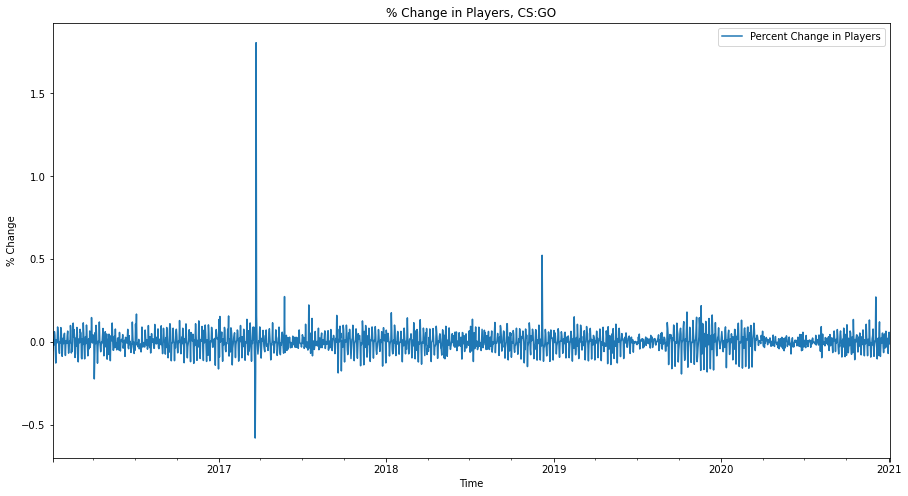

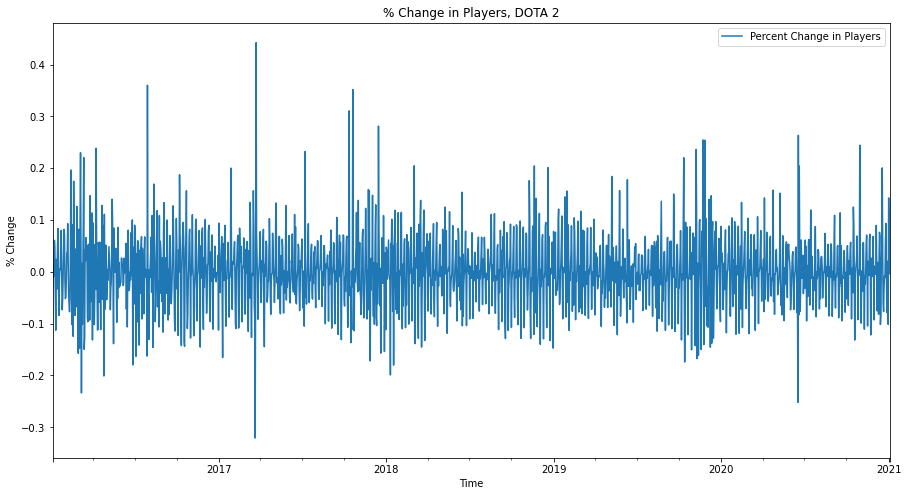

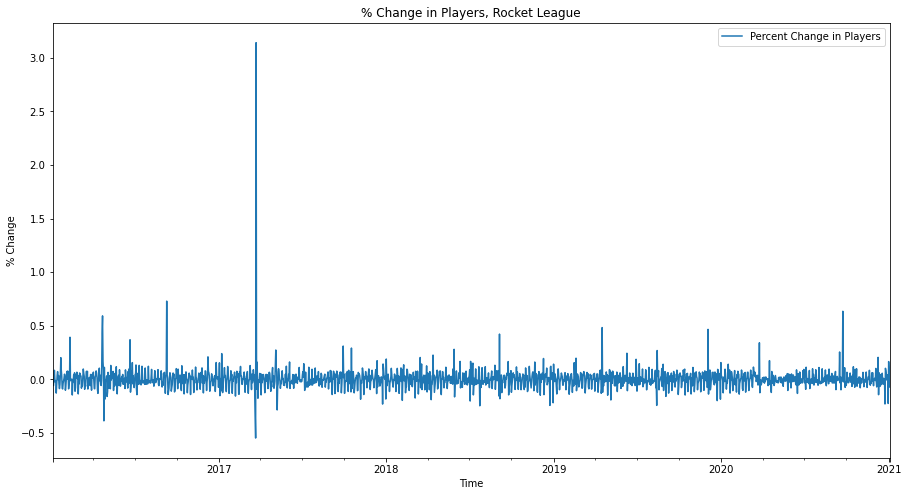

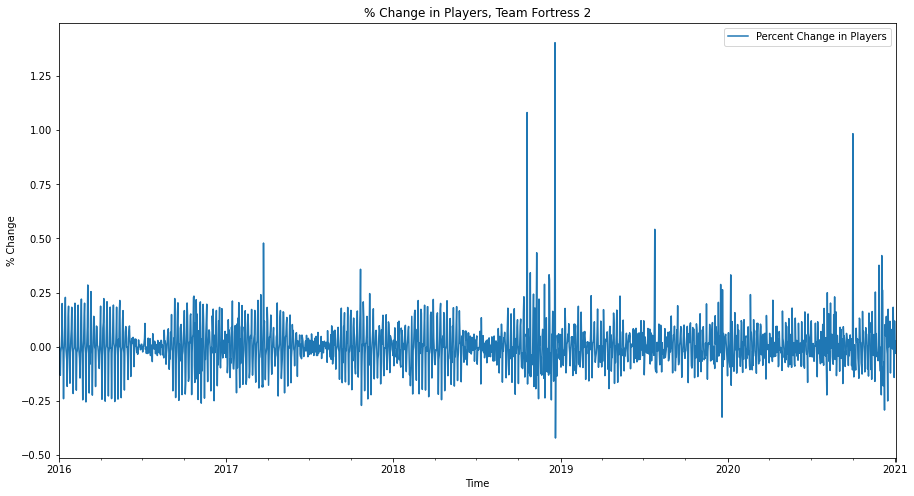

In [43]:
# visualizing this feature
for i, df in enumerate(ls):
    
    df.plot(y = '%chg_players', label = 'Percent Change in Players', figsize = (15,8),
           xlabel = 'Time', ylabel = '% Change', title = "% Change in Players, "+ labels[i])


In [44]:
# we should average our data before removing outliers

average_pc = []

for i in range(len(ls[0])):
    pc = '%chg_players'
    average_at_i = np.array([ls[0][pc][i], ls[1][pc][i], ls[2][pc][i], ls[3][pc][i]]).mean() 
    average_pc.append(average_at_i)

df_model = ls[0].copy()
df_model["mean_%chg_players"] = average_pc
df_model = pd.DataFrame(df_model['mean_%chg_players'])

df_model

mean_%chg_players
DateTime                     
2016-01-04          -0.028664
2016-01-05          -0.014695
2016-01-06          -0.019099
2016-01-07          -0.035620
2016-01-08           0.045607
...                       ...
2020-12-30           0.011848
2020-12-31          -0.053178
2021-01-01           0.082226
2021-01-02           0.016156
2021-01-03           0.008673

[1827 rows x 1 columns]

In [45]:
# checking our stationarity with ADF test


    
df = df_model.dropna()
result = adfuller(df)
print("ADF Test : Mean Model")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('')

ADF Test : Mean Model
ADF Statistic: -9.935198
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



In [46]:
# while our data is already stationary, we have to address outliers, much like we did before with our logged differences. 

outlier_removed = []

IQR = scipy.stats.iqr(df_model)
mean = df_model.mean()
quantiles = df_model["mean_%chg_players"].quantile([0.25, 0.75])
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
upper = Q3 + 3*IQR
lower = Q1 - 3*IQR
for val in df_model["mean_%chg_players"]:
        if val > upper:
            outlier_removed.append(df_model["mean_%chg_players"][i-1])
        elif val < lower:
            outlier_removed.append(df_model["mean_%chg_players"][i-1])
        else:
            outlier_removed.append(val)
df_model['PCOR'] = outlier_removed

df_model = pd.DataFrame(df_model['PCOR'])

df_model



PCOR
DateTime            
2016-01-04 -0.028664
2016-01-05 -0.014695
2016-01-06 -0.019099
2016-01-07 -0.035620
2016-01-08  0.045607
...              ...
2020-12-30  0.011848
2020-12-31 -0.053178
2021-01-01  0.082226
2021-01-02  0.016156
2021-01-03  0.008673

[1827 rows x 1 columns]

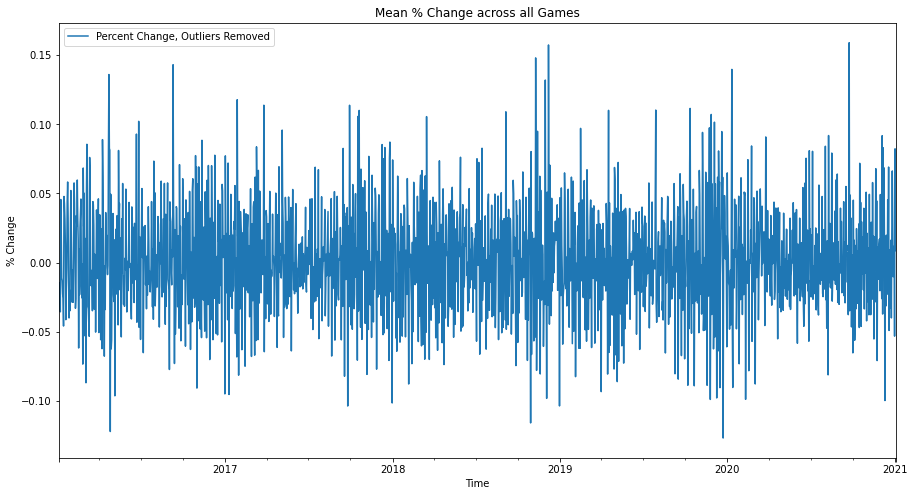

In [47]:
# inspecting how this impacted our visualizations

df_plot = df_model['PCOR']
df_plot.plot(label = "Percent Change, Outliers Removed", figsize = (15, 8),
            xlabel = 'Time', ylabel = '% Change', title = "Mean % Change across all Games")
plt.legend()
plt.show()

Data is ready to be modelled!

As before, we need to first ensure that our seasonality was not affected by our transformations so far. 

### Modelling

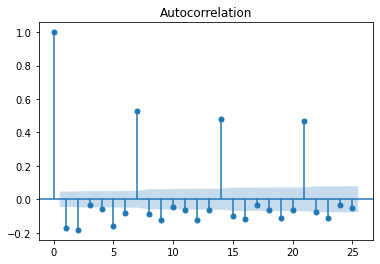

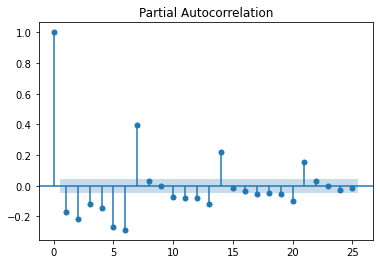

In [48]:
# plotting acf and pacf, showing that our seasonality is retained at s = 7

acf = plot_acf(df_model, lags = 25)
pacf = plot_pacf(df_model, lags = 25)

In [49]:
# defining our parameters for our gridsearch.

p = q = range(0, 3)
d = [0]
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]




In [50]:

mods = []
for comb in pdq:
    for combs in pdqs:
        model = SARIMAX(df_model, 
                       order = comb,
                       seasonal_order = combs,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
        output = model.fit()
        mods.append([comb, combs, output.aic])
        print('ARIMA {} X {} : AIC Calculated = {}'.format(comb, combs, round(output.aic, 2)))
models_df = pd.DataFrame(mods, columns = ['pdq', 'pdqs', 'aic'])
best_model = models_df.loc[models_df['aic'].idxmin()].dropna()
    

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

ARIMA (0, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6689.68
ARIMA (0, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6784.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 2, 0, 7) : AIC Calculated = -4827.21
ARIMA (0, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7269.79
ARIMA (0, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -7162.99


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 2, 0, 7) : AIC Calculated = -5757.57


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (2, 0, 0, 7) : AIC Calculated = -7384.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (2, 1, 0, 7) : AIC Calculated = -7307.07


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (2, 2, 0, 7) : AIC Calculated = -6208.05
ARIMA (0, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5142.37
ARIMA (0, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5216.26


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-package

ARIMA (0, 1, 0) X (0, 2, 0, 7) : AIC Calculated = -3262.47
ARIMA (0, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -5707.77


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5604.09


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 2, 0, 7) : AIC Calculated = -4215.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (2, 0, 0, 7) : AIC Calculated = -5827.05
ARIMA (0, 1, 0) X (2, 1, 0, 7) : AIC Calculated = -5739.95


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (2, 2, 0, 7) : AIC Calculated = -4646.89
ARIMA (0, 2, 0) X (0, 0, 0, 7) : AIC Calculated = -3141.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) X (0, 1, 0, 7) : AIC Calculated = -3169.1
ARIMA (0, 2, 0) X (0, 2, 0, 7) : AIC Calculated = -1217.55
ARIMA (0, 2, 0) X (1, 0, 0, 7) : AIC Calculated = -3675.87
ARIMA (0, 2, 0) X (1, 1, 0, 7) : AIC Calculated = -3575.67

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) X (1, 2, 0, 7) : AIC Calculated = -2190.62
ARIMA (0, 2, 0) X (2, 0, 0, 7) : AIC Calculated = -3803.93


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) X (2, 1, 0, 7) : AIC Calculated = -3719.2


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 2, 0) X (2, 2, 0, 7) : AIC Calculated = -2624.23
ARIMA (1, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6737.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6843.37
ARIMA (1, 0, 0) X (0, 2, 0, 7) : AIC Calculated = -4887.65


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7320.66


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -7216.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 2, 0, 7) : AIC Calculated = -5806.79


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (2, 0, 0, 7) : AIC Calculated = -7436.73


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (2, 1, 0, 7) : AIC Calculated = -7365.25


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (2, 2, 0, 7) : AIC Calculated = -6267.22
ARIMA (1, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5652.22


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5839.7
ARIMA (1, 1, 0) X (0, 2, 0, 7) : AIC Calculated = -3901.35
ARIMA (1, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -6292.49


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -6195.82
ARIMA (1, 1, 0) X (1, 2, 0, 7) : AIC Calculated = -4816.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (2, 0, 0, 7) : AIC Calculated = -6408.03


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (2, 1, 0, 7) : AIC Calculated = -6327.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (2, 2, 0, 7) : AIC Calculated = -5258.31
ARIMA (1, 2, 0) X (0, 0, 0, 7) : AIC Calculated = -4109.12
ARIMA (1, 2, 0) X (0, 1, 0, 7) : AIC Calculated = -4253.21

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) X (0, 2, 0, 7) : AIC Calculated = -2319.12
ARIMA (1, 2, 0) X (1, 0, 0, 7) : AIC Calculated = -4720.26


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) X (1, 1, 0, 7) : AIC Calculated = -4618.13
ARIMA (1, 2, 0) X (1, 2, 0, 7) : AIC Calculated = -3248.14


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) X (2, 0, 0, 7) : AIC Calculated = -4836.5


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) X (2, 1, 0, 7) : AIC Calculated = -4752.74


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 2, 0) X (2, 2, 0, 7) : AIC Calculated = -3688.31
ARIMA (2, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6813.18


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6865.62


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (0, 2, 0, 7) : AIC Calculated = -4905.95


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7356.14


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -7248.13


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (1, 2, 0, 7) : AIC Calculated = -5829.6
ARIMA (2, 0, 0) X (2, 0, 0, 7) : AIC Calculated = -7474.09


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (2, 1, 0, 7) : AIC Calculated = -7405.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 0, 0) X (2, 2, 0, 7) : AIC Calculated = -6294.84
ARIMA (2, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5993.53


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -6206.03
ARIMA (2, 1, 0) X (0, 2, 0, 7) : AIC Calculated = -4264.02


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -6650.01


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -6568.2


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (1, 2, 0, 7) : AIC Calculated = -5178.22


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (2, 0, 0, 7) : AIC Calculated = -6774.82
ARIMA (2, 1, 0) X (2, 1, 0, 7) : AIC Calculated = -6705.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 1, 0) X (2, 2, 0, 7) : AIC Calculated = -5624.43
ARIMA (2, 2, 0) X (0, 0, 0, 7) : AIC Calculated = -4739.19
ARIMA (2, 2, 0) X (0, 1, 0, 7) : AIC Calculated = -4935.14

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (0, 2, 0, 7) : AIC Calculated = -3006.58


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (1, 0, 0, 7) : AIC Calculated = -5384.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (1, 1, 0, 7) : AIC Calculated = -5292.03


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (1, 2, 0, 7) : AIC Calculated = -3914.39


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (2, 0, 0, 7) : AIC Calculated = -5503.5


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (2, 1, 0, 7) : AIC Calculated = -5429.14


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (2, 2, 0) X (2, 2, 0, 7) : AIC Calculated = -4359.71


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [51]:
print(best_model)

pdq        (2, 0, 0)
pdqs    (2, 0, 0, 7)
aic         -7474.09
Name: 60, dtype: object


### Validation

In [52]:
# we generate summary stats for the model

mean_model = SARIMAX(df_model,
             order = best_model.loc['pdq'],
                    seasonal_order = best_model.loc['pdqs'],
             enforce_stationarity = False,
             enforce_invertibility = False)
output = mean_model.fit()
print(output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2052      0.019    -10.742      0.000      -0.243      -0.168
ar.L2         -0.1551      0.020     -7.918      0.000      -0.193      -0.117
ar.S.L7        0.3750      0.019     19.895      0.000       0.338       0.412
ar.S.L14       0.2813      0.020     14.085      0.000       0.242       0.320
sigma2         0.0009    2.3e-05     40.889      0.000       0.001       0.001


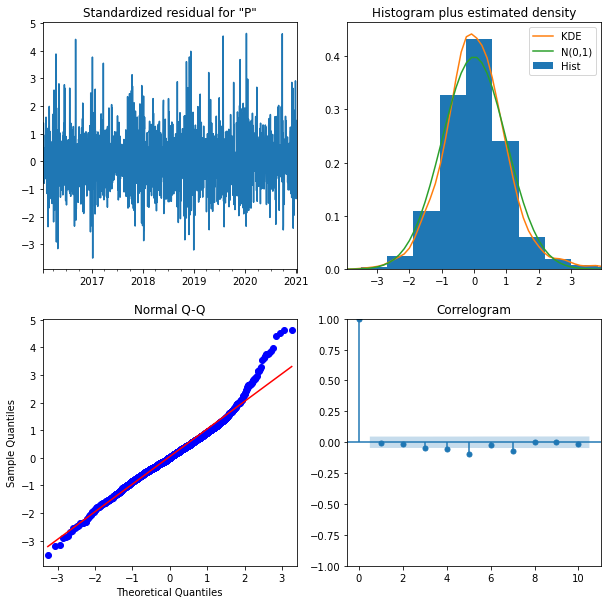

In [53]:
# we visualize validation plots

output.plot_diagnostics(figsize = (10, 10))
plt.show()

#### Forecasting 

We will forecast and calculate the mean squared error for each dataframe, using our constructed model. 

In [54]:
# we generate predictions

pred = output.get_prediction(start = pd.to_datetime("2020-12-15"))
conf_int = pred.conf_int()

forecast = pred.predicted_mean

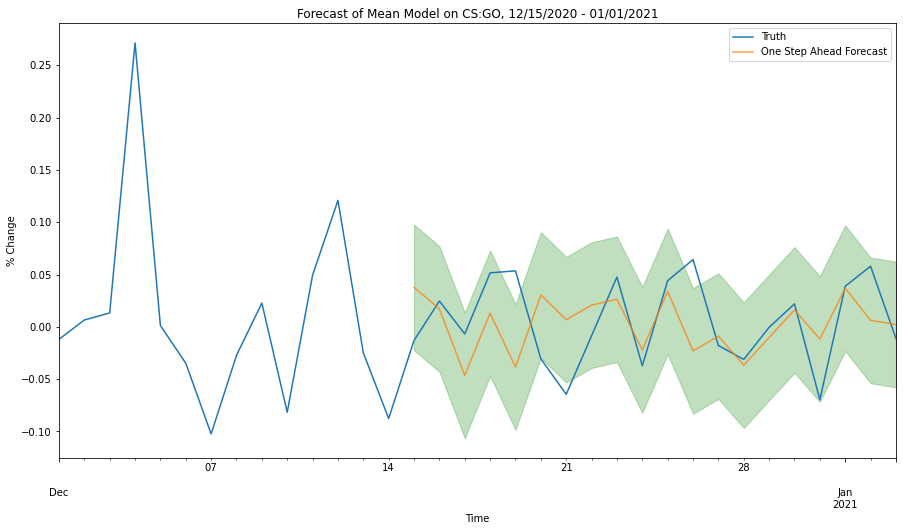

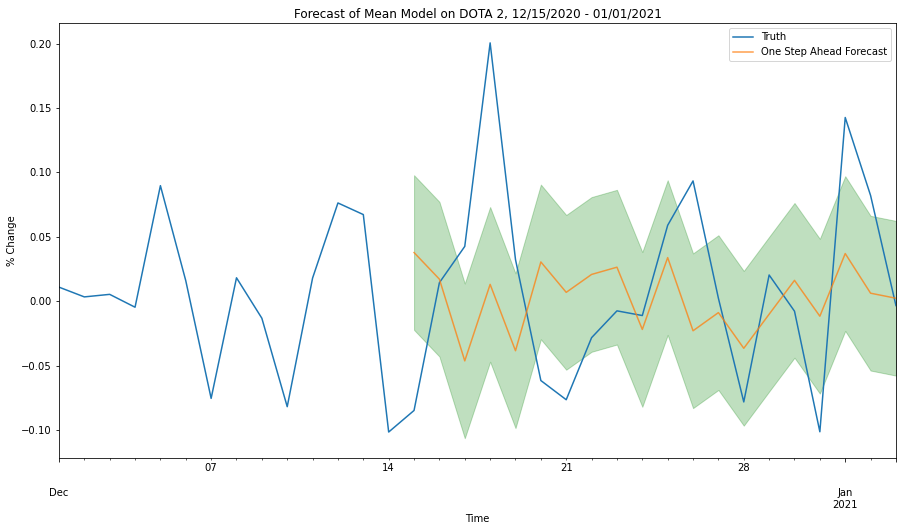

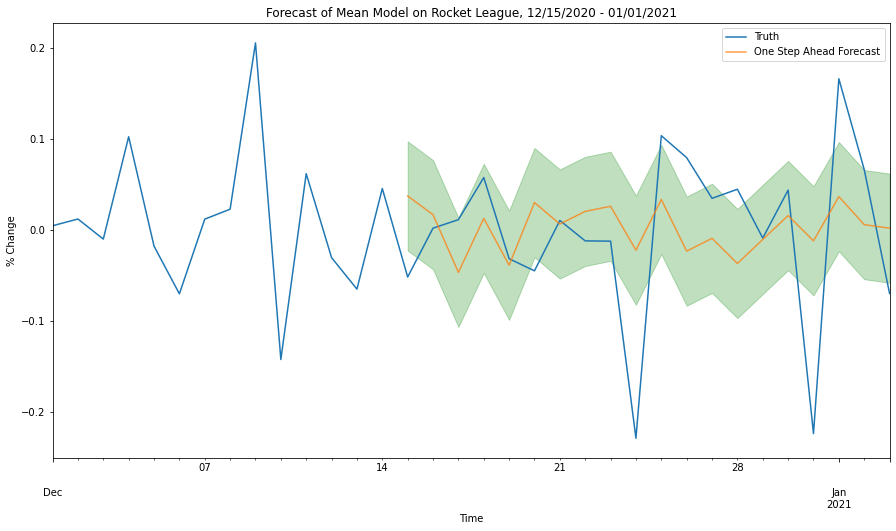

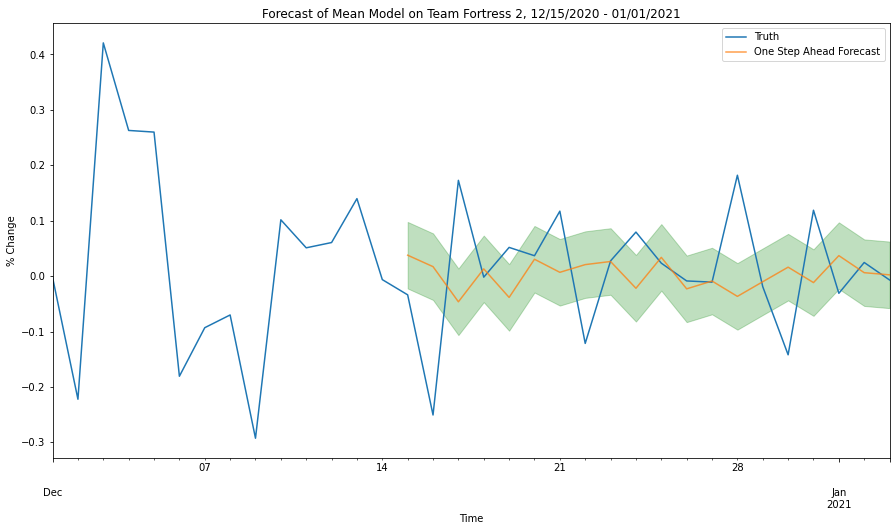

In [55]:
# and visualize the forecasts for each of our dataframes


for i, df in enumerate(ls_w_outliers):
    ax = df['2020-12-01':].plot(y = '%chg_players', label = 'Truth', figsize = (15, 8),
                               xlabel = "Time", ylabel = "% Change",
                               title = 'Forecast of Mean Model on '+labels[i]+', 12/15/2020 - 01/01/2021')
    forecast.plot(ax = ax, label = "One Step Ahead Forecast", alpha = 0.75)
    
    ax.fill_between(conf_int.index,
                   conf_int.iloc[:,0],
                   conf_int.iloc[:,1], color = 'g', alpha = 0.25)
    
    plt.legend()
    plt.show()
    


In [56]:
# finally, we calculate the MSE for each of these forecasts. 

for df in ls_w_outliers:
    forecasted = pred.predicted_mean
    truth = df["2020-12-15":]['%chg_players']
    mse = ((forecasted - truth) ** 2).mean()
    print(mse)

0.0019330954792472041
0.006236304052738983
0.008003758661195324
0.013564270673069909


### Conclusions on Amalgamized Modelling

We constructed one model from the mean change in players for all of our games. This model's summary statistics show that it is more viable than our basic models in part 1, due to the fact that our validation visualizations, namely the QQ plot suggesting that residuals in this model are more normally distributed than for all other models constructed thus far.

This model also has the benefit of being able to be applied to any game. 

In [57]:
# we save all of our constructed models for use in the next notebook

import pickle

models.append(mean_model)

names = ["models/csgo_model.pkl",
"models/dota_model.pkl",
"models/rl_model.pkl",
"models/tf_model.pkl",
"models/mean_model.pkl"]

for i in range(len(models)):
    with open(names[i], 'wb') as file:
        pickle.dump(models[i], file)

In [58]:
# we also save our training and testing dataframes

names = ['csgo_test.csv',
        'dota_test.csv',
        'rl_test.csv',
        'tf_test.csv']

for i in range(len(ls_w_outliers)):
    ls_w_outliers[i].to_csv('data/Test/'+names[i])
    


## Next:

In the next notebook, we will compare our models and describe the pros and cons of each, while also using models to find interesting points in the future. We will also provide our recommendations to those looking to utilize our findings, and conclude with thoughts on how our investigation could have yeilded more insight into these data. 